In [ ]:
# Importing libraries for data manipulation, model building, and evaluation
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Mounting Google Drive to access datasets or files stored on Google Drive in Colab environment
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing the pandas library for data manipulation
import pandas as pd

# Link to the dataset stored in Google Drive
direct_link = 'https://drive.google.com/uc?id=1Kd9Aw1_xAdobirmXt6wSeC-maxHy4vd2'

# Loading the dataset into a pandas DataFrame from the given link, with specific encoding to handle special characters
data = pd.read_csv(direct_link, encoding='ISO-8859-1')


# Displaying the first few rows of the dataset to verify that it's loaded correctly
data.head()



,S. No.,Timestamp,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,GADE,...,Birthplace,Residence,Reference,Playstyle,accept,GAD_T,SWL_T,SPIN_T,Residence_ISO3,Birthplace_ISO3
0,1,42052.00437,0,0,0,0,1,0,0,Not difficult at all,...,USA,USA,Reddit,Singleplayer,Accept,1,23,5.0,USA,USA
1,2,42052.00680,1,2,2,2,0,1,0,Somewhat difficult,...,USA,USA,Reddit,Multiplayer - online - with strangers,Accept,8,16,33.0,USA,USA
2,3,42052.03860,0,2,2,0,0,3,1,Not difficult at all,...,Germany,Germany,Reddit,Singleplayer,Accept,8,17,31.0,DEU,DEU
3,4,42052.06804,0,0,0,0,0,0,0,Not difficult at all,...,USA,USA,Reddit,Multiplayer - online - with online acquaintanc...,Accept,0,17,11.0,USA,USA
4,5,42052.08948,2,1,2,2,2,3,2,Very difficult,...,USA,South Korea,Reddit,Multiplayer - online - with strangers,Accept,14,14,13.0,KOR,USA


In [ ]:
# Printing the dimensions of the dataset (rows, columns) to understand its size
print(data.shape)


(13464, 55)


In [ ]:

data = data.dropna(subset=['GAD_T', 'SWL_T', 'SPIN_T'])
data['Hours'] = data['Hours'].fillna(data['Hours'].mean())


def categorize_anxiety(score):
    if score <= 4:
        return 'Minimal'
    elif score <= 9:
        return 'Mild'
    elif score <= 14:
        return 'Moderate'
    else:
        return 'Severe'

data['Anxiety_Level'] = data['GAD_T'].apply(categorize_anxiety)


data[['GAD_T', 'Anxiety_Level', 'Hours']].head()


<ipython-input-42-55a268035c77>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Hours'] = data['Hours'].fillna(data['Hours'].mean())
<ipython-input-42-55a268035c77>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Anxiety_Level'] = data['GAD_T'].apply(categorize_anxiety)


,GAD_T,Anxiety_Level,Hours
0,1,Minimal,15.0
1,8,Mild,8.0
2,8,Mild,0.0
3,0,Minimal,20.0
4,14,Moderate,20.0


In [ ]:
# Importing necessary libraries for data handling, preprocessing, model building, and evaluation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Loading dataset from Google Drive link, handling missing values in 'Hours' by filling with the mean
data = pd.read_csv('https://drive.google.com/uc?id=1Kd9Aw1_xAdobirmXt6wSeC-maxHy4vd2', encoding='ISO-8859-1')
data['Hours'].fillna(data['Hours'].mean(), inplace=True)  # Fill missing 'Hours' with the mean
data.dropna(subset=['GAD_T', 'SWL_T', 'SPIN_T'], inplace=True)  # Dropping rows with missing values in critical columns

# Defining the feature matrix (X) and the target variable (y)
X = data[['Hours', 'GAD_T', 'SWL_T', 'SPIN_T']]
y = data['GAD_T'] > 10  # Binary target: True if GAD_T > 10 (high anxiety)

# Splitting the dataset into training and test sets (80% training, 20% testing)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features for better model performance (standardization)
scaler = StandardScaler().fit(X_train_full)
X_train_full_scaled = scaler.transform(X_train_full)  # Scaling the training data
X_test_scaled = scaler.transform(X_test)  # Scaling the test data

# Setting up K-Fold cross-validation with 5 splits to assess model performance across different subsets of data
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store accuracy and loss scores for each fold
acc_scores = []
loss_scores = []

# Looping through each fold of cross-validation
for train_index, val_index in kf.split(X_train_full_scaled):
    # Splitting data into training and validation sets for the current fold
    X_train, X_val = X_train_full_scaled[train_index], X_train_full_scaled[val_index]
    y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]

    # Defining a simple neural network model with dropout layers to prevent overfitting
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # First hidden layer with 64 units
        Dropout(0.3),  # Dropout layer to prevent overfitting
        Dense(32, activation='relu'),  # Second hidden layer with 32 units
        Dropout(0.3),  # Dropout layer
        Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
    ])

    # Compiling the model using the Adam optimizer and binary crossentropy loss
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Training the model with the training data for the current fold, using the validation set for evaluation
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)

    # Evaluating the model on the validation set and storing accuracy and loss scores
    loss, acc = model.evaluate(X_val, y_val, verbose=0)
    acc_scores.append(acc)
    loss_scores.append(loss)

# Outputting the average accuracy and loss across all folds of cross-validation
print(f"Cross-Validation - Average Accuracy: {np.mean(acc_scores)}, Average Loss: {np.mean(loss_scores)}")

# Making predictions on the test set
y_pred = model.predict(X_test_scaled)
y_pred = (y_pred > 0.5).astype(int)  # Converting predicted probabilities to binary labels

# Calculating precision, recall, and F1 score for the test set predictions
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Outputting the precision, recall, and F1 score for the test set
print(f"Test Set - Precision: {precision}, Recall: {recall}, F1 Score: {f1}")


<ipython-input-44-47e000951eaa>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Hours'].fillna(data['Hours'].mean(), inplace=True)  # Fill missing 'Hours' with the mean
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Cross-Validation - Average Accuracy: 1.0, Average Loss: 0.0004904303466901183
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Set - Precision: 1.0, Recall: 1.0, F1 Score: 1.0


In [ ]:
# Importing necessary layers for the model from TensorFlow Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Reshaping the training and test sets to 3D shape required by LSTM (samples, timesteps, features)
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Initializing the sequential model
model = Sequential()

# Adding an LSTM layer with 50 units, and specifying the input shape (timesteps, features)
model.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))

# Adding a Dropout layer to prevent overfitting, with a dropout rate of 20%
model.add(Dropout(0.2))

# Adding a Dense output layer with a sigmoid activation function for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compiling the model with Adam optimizer and binary crossentropy as the loss function for binary classification
# Also tracking accuracy as a performance metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model on the training data with 20 epochs, batch size of 32, and validating on the test set
model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test), verbose=2)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


337/337 - 3s - 9ms/step - accuracy: 0.8466 - loss: 0.5037 - val_accuracy: 0.8567 - val_loss: 0.4113
Epoch 2/20
337/337 - 2s - 7ms/step - accuracy: 0.8552 - loss: 0.4114 - val_accuracy: 0.8567 - val_loss: 0.4102
Epoch 3/20
337/337 - 2s - 7ms/step - accuracy: 0.8551 - loss: 0.4115 - val_accuracy: 0.8570 - val_loss: 0.4097
Epoch 4/20
337/337 - 2s - 6ms/step - accuracy: 0.8549 - loss: 0.4111 - val_accuracy: 0.8567 - val_loss: 0.4096
Epoch 5/20
337/337 - 2s - 7ms/step - accuracy: 0.8550 - loss: 0.4110 - val_accuracy: 0.8567 - val_loss: 0.4092
Epoch 6/20
337/337 - 2s - 7ms/step - accuracy: 0.8550 - loss: 0.4104 - val_accuracy: 0.8567 - val_loss: 0.4090
Epoch 7/20
337/337 - 1s - 4ms/step - accuracy: 0.8549 - loss: 0.4112 - val_accuracy: 0.8567 - val_loss: 0.4089
Epoch 8/20
337/337 - 2s - 5ms/step - accuracy: 0.8550 - loss: 0.4110 - val_accuracy: 0.8567 - val_loss: 0.4087
Epoch 9/20
337/337 - 3s - 9ms/step - accuracy: 0.8550 - loss: 0.4103 - val_accuracy: 0.8567 - val_loss: 0.4087
Epoch 10/20


In [ ]:
# Importing necessary libraries for data handling, preprocessing, and splitting
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Loading the dataset from Google Drive link with specific encoding
data = pd.read_csv('https://drive.google.com/uc?id=1Kd9Aw1_xAdobirmXt6wSeC-maxHy4vd2', encoding='ISO-8859-1')

# Filling missing numerical values in the dataset with the mean of each column
data.fillna(data.mean(numeric_only=True), inplace=True)

# Initializing a StandardScaler to normalize numerical features
scaler = StandardScaler()

# Selecting numerical features (e.g., Hours spent gaming and Age) for scaling
numerical_features = ['Hours', 'Age']

# Applying the scaler to standardize the numerical features
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Defining the feature set X and target variable y
# Target 'y' is set to True for 'GAD_T' scores greater than 10 (indicating higher anxiety)
X = data[numerical_features]
y = data['GAD_T'] > 10  # Binary target based on GAD_T anxiety score

# Splitting the data into training and test sets (80% training, 20% testing), with a fixed random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Evaluating the trained model on the test set to calculate loss and accuracy
loss, accuracy = model.evaluate(X_test_reshaped, y_test, verbose=2)

# Printing the test loss and accuracy for the model's performance on unseen data
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


85/85 - 0s - 2ms/step - accuracy: 0.8567 - loss: 0.4084
Test Loss: 0.4083610475063324, Test Accuracy: 0.8566654324531555


In [ ]:

history = model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test), verbose=2)


Epoch 1/20
337/337 - 2s - 4ms/step - accuracy: 0.8550 - loss: 0.4106 - val_accuracy: 0.8567 - val_loss: 0.4084
Epoch 2/20
337/337 - 1s - 4ms/step - accuracy: 0.8551 - loss: 0.4105 - val_accuracy: 0.8567 - val_loss: 0.4084
Epoch 3/20
337/337 - 3s - 7ms/step - accuracy: 0.8550 - loss: 0.4115 - val_accuracy: 0.8570 - val_loss: 0.4083
Epoch 4/20
337/337 - 1s - 4ms/step - accuracy: 0.8551 - loss: 0.4107 - val_accuracy: 0.8570 - val_loss: 0.4083
Epoch 5/20
337/337 - 2s - 6ms/step - accuracy: 0.8550 - loss: 0.4116 - val_accuracy: 0.8570 - val_loss: 0.4082
Epoch 6/20
337/337 - 2s - 6ms/step - accuracy: 0.8550 - loss: 0.4106 - val_accuracy: 0.8570 - val_loss: 0.4081
Epoch 7/20
337/337 - 2s - 6ms/step - accuracy: 0.8550 - loss: 0.4105 - val_accuracy: 0.8570 - val_loss: 0.4081
Epoch 8/20
337/337 - 1s - 4ms/step - accuracy: 0.8551 - loss: 0.4106 - val_accuracy: 0.8570 - val_loss: 0.4082
Epoch 9/20
337/337 - 2s - 5ms/step - accuracy: 0.8551 - loss: 0.4105 - val_accuracy: 0.8570 - val_loss: 0.4082
E

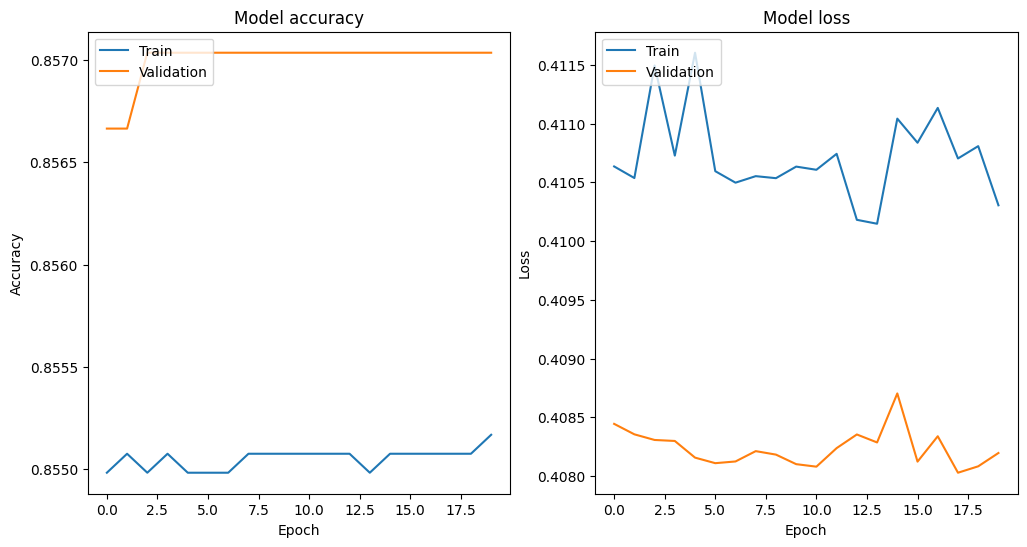

In [ ]:
# Importing matplotlib for plotting
import matplotlib.pyplot as plt

# Function to plot the training history of the model, showing both accuracy and loss over epochs
def plot_training_history(history):

    # Creating a figure for plotting
    plt.figure(figsize=(12, 6))

    # Subplot 1: Plotting model accuracy for both training and validation sets
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])  # Training accuracy
    plt.plot(history.history['val_accuracy'])  # Validation accuracy
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')  # Adding a legend

    # Subplot 2: Plotting model loss for both training and validation sets
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])  # Training loss
    plt.plot(history.history['val_loss'])  # Validation loss
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')  # Adding a legend

    # Display the plots
    plt.show()

# Calling the function to plot training history using the 'history' object from model training
plot_training_history(history)


In [ ]:
# Importing LogisticRegression from sklearn for building a logistic regression model
from sklearn.linear_model import LogisticRegression

# Importing classification_report and accuracy_score to evaluate the model's performance
from sklearn.metrics import classification_report, accuracy_score


In [ ]:
# Importing RandomForestClassifier from sklearn for building a random forest model
from sklearn.ensemble import RandomForestClassifier


In [ ]:
# Importing necessary layers for building a 1D Convolutional Neural Network (CNN) in Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Initializing a Sequential model for a 1D CNN
model = Sequential()

# Adding a 1D Convolutional layer with 64 filters, kernel size of 1, and ReLU activation
# The input shape is based on reshaped training data (timesteps, features)
model.add(Conv1D(64, kernel_size=1, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))

# Adding a 1D Max Pooling layer with a pool size of 1 to downsample the data
model.add(MaxPooling1D(pool_size=1))

# Flattening the output from the previous layer to feed into the Dense (fully connected) layer
model.add(Flatten())

# Adding a Dense output layer with a sigmoid activation function for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compiling the model using the Adam optimizer, binary crossentropy loss function (for binary classification), and tracking accuracy
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model on the reshaped training data with 20 epochs, batch size of 32, and validating on the test data
model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test), verbose=2)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


337/337 - 3s - 8ms/step - accuracy: 0.8476 - loss: 0.4593 - val_accuracy: 0.8570 - val_loss: 0.4148
Epoch 2/20
337/337 - 1s - 2ms/step - accuracy: 0.8551 - loss: 0.4114 - val_accuracy: 0.8567 - val_loss: 0.4120
Epoch 3/20
337/337 - 1s - 2ms/step - accuracy: 0.8551 - loss: 0.4105 - val_accuracy: 0.8567 - val_loss: 0.4131
Epoch 4/20
337/337 - 1s - 2ms/step - accuracy: 0.8551 - loss: 0.4100 - val_accuracy: 0.8567 - val_loss: 0.4133
Epoch 5/20
337/337 - 1s - 2ms/step - accuracy: 0.8551 - loss: 0.4102 - val_accuracy: 0.8567 - val_loss: 0.4147
Epoch 6/20
337/337 - 1s - 2ms/step - accuracy: 0.8551 - loss: 0.4100 - val_accuracy: 0.8567 - val_loss: 0.4159
Epoch 7/20
337/337 - 1s - 2ms/step - accuracy: 0.8551 - loss: 0.4100 - val_accuracy: 0.8567 - val_loss: 0.4160
Epoch 8/20
337/337 - 1s - 4ms/step - accuracy: 0.8551 - loss: 0.4098 - val_accuracy: 0.8567 - val_loss: 0.4150
Epoch 9/20
337/337 - 1s - 2ms/step - accuracy: 0.8551 - loss: 0.4096 - val_accuracy: 0.8567 - val_loss: 0.4157
Epoch 10/20


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


337/337 - 6s - 19ms/step - accuracy: 0.8448 - loss: 0.4922 - val_accuracy: 0.8570 - val_loss: 0.4348
Epoch 2/50
337/337 - 6s - 17ms/step - accuracy: 0.8552 - loss: 0.4318 - val_accuracy: 0.8570 - val_loss: 0.4216
Epoch 3/50
337/337 - 1s - 2ms/step - accuracy: 0.8552 - loss: 0.4241 - val_accuracy: 0.8570 - val_loss: 0.4154
Epoch 4/50
337/337 - 1s - 4ms/step - accuracy: 0.8552 - loss: 0.4193 - val_accuracy: 0.8570 - val_loss: 0.4126
Epoch 5/50
337/337 - 1s - 2ms/step - accuracy: 0.8552 - loss: 0.4210 - val_accuracy: 0.8570 - val_loss: 0.4108
Epoch 6/50
337/337 - 1s - 4ms/step - accuracy: 0.8552 - loss: 0.4195 - val_accuracy: 0.8570 - val_loss: 0.4108
Epoch 7/50
337/337 - 1s - 4ms/step - accuracy: 0.8552 - loss: 0.4184 - val_accuracy: 0.8570 - val_loss: 0.4094
Epoch 8/50
337/337 - 1s - 4ms/step - accuracy: 0.8552 - loss: 0.4182 - val_accuracy: 0.8570 - val_loss: 0.4106
Epoch 9/50
337/337 - 1s - 2ms/step - accuracy: 0.8552 - loss: 0.4166 - val_accuracy: 0.8570 - val_loss: 0.4089
Epoch 10/5

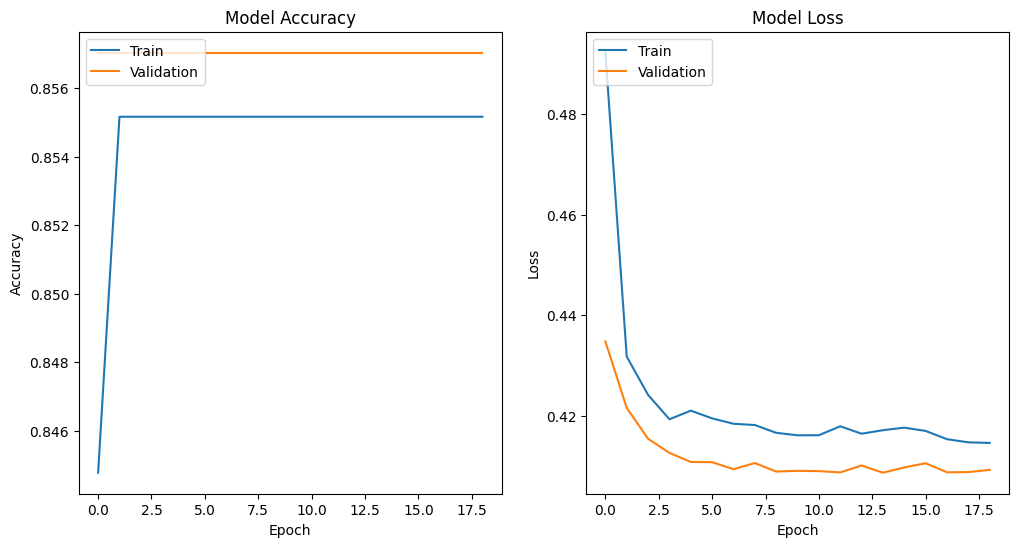

In [ ]:
# Importing necessary libraries for data handling, preprocessing, model building, training, and plotting
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Loading the dataset from Google Drive and handling missing values by filling them with the mean for numeric columns
data = pd.read_csv('https://drive.google.com/uc?id=1Kd9Aw1_xAdobirmXt6wSeC-maxHy4vd2', encoding='ISO-8859-1')
data.fillna(data.mean(numeric_only=True), inplace=True)

# Defining features (Hours and Age) and target variable (binary classification based on GAD_T score > 10)
X = data[['Hours', 'Age']]
y = data['GAD_T'] > 10  # Binary target: True if GAD_T > 10 (high anxiety)

# Standardizing the feature set for normalized input into the model
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Augmenting the dataset by horizontally stacking the feature matrix (simulates more time steps for Conv1D input)
X_train_augmented = np.hstack([X, X])  # Doubling the feature set
X_test_augmented = np.hstack([X, X])   # Same augmentation for the test set

# Splitting the augmented dataset into training and testing sets (80% train, 20% test)
X_train_augmented, X_test_augmented, y_train, y_test = train_test_split(X_train_augmented, y, test_size=0.2, random_state=42)

# Reshaping the feature matrices to 3D for Conv1D layers (samples, timesteps, features per timestep)
num_time_steps = 2
X_train_reshaped = X_train_augmented.reshape((X_train_augmented.shape[0], num_time_steps, X_train_augmented.shape[1] // num_time_steps))
X_test_reshaped = X_test_augmented.reshape((X_test_augmented.shape[0], num_time_steps, X_test_augmented.shape[1] // num_time_steps))

# Building a 1D Convolutional Neural Network (CNN) model
model = Sequential()

# First Conv1D layer with 256 filters, kernel size of 1, ReLU activation, and input shape from the reshaped training data
model.add(Conv1D(256, kernel_size=1, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(MaxPooling1D(pool_size=1))  # MaxPooling layer to reduce dimensionality
model.add(Dropout(0.5))  # Dropout to prevent overfitting

# Second Conv1D layer with 128 filters
model.add(Conv1D(128, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(pool_size=1))  # Another pooling layer to downsample
model.add(Dropout(0.5))

# Flattening the data for fully connected layers
model.add(Flatten())

# Fully connected Dense layer with 128 units and ReLU activation
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout to reduce overfitting

# Output layer with 1 unit and sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compiling the model with the Adam optimizer, binary crossentropy loss, and tracking accuracy as a metric
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# EarlyStopping callback to stop training if validation loss doesn't improve for 5 epochs and restore best weights
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the model on the training set, validating on the test set, for 50 epochs with early stopping
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_data=(X_test_reshaped, y_test),
                    callbacks=[early_stopping], verbose=2)

# Evaluating the model on the test set and printing the test loss and accuracy
loss, accuracy = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

# Function to plot the training history: accuracy and loss for both training and validation sets
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Subplot for accuracy over epochs
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Subplot for loss over epochs
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Display the plots
    plt.show()

# Plotting the training and validation accuracy and loss over the training epochs
plot_training_history(history)


In [ ]:
# Importing necessary libraries for data handling, model building, evaluation, and preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV  # For splitting data and hyperparameter tuning
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score  # For model evaluation
from imblearn.over_sampling import SMOTE  # Handling class imbalance
from sklearn.pipeline import Pipeline  # For building machine learning pipelines

# Loading the dataset from Google Drive and handling missing values by filling with mean for numeric columns
data = pd.read_csv('https://drive.google.com/uc?id=1Kd9Aw1_xAdobirmXt6wSeC-maxHy4vd2', encoding='ISO-8859-1')
data.fillna(data.mean(numeric_only=True), inplace=True)

# Feature engineering: creating interaction terms and polynomial features
data['Age_Hours'] = data['Hours'] * data['Age']  # Interaction between Hours and Age
data['Hours_Squared'] = data['Hours'] ** 2  # Squaring Hours to capture non-linear effects
data['Age_Squared'] = data['Age'] ** 2  # Squaring Age to capture non-linear effects

# Defining features (X) and the target variable (y)
X = data[['Hours', 'Age', 'Age_Hours', 'Hours_Squared', 'Age_Squared']]
y = data['GAD_T'] > 10  # Binary classification: True if GAD_T > 10 (high anxiety)

# Handling class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Splitting the resampled dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Scaling the features using StandardScaler
scaler = StandardScaler()

# Creating a pipeline for Logistic Regression including scaling and model training
log_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling step
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))  # Logistic Regression model
])

# Defining the hyperparameter grid for Logistic Regression
logreg_param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Regularization strength (C values)
}

# Using GridSearchCV to perform hyperparameter tuning with cross-validation (cv=5)
logreg_grid = GridSearchCV(log_reg_pipeline, logreg_param_grid, cv=5, scoring='accuracy', verbose=2)
logreg_grid.fit(X_train, y_train)

# Outputting the best hyperparameters and the best cross-validation accuracy for Logistic Regression
print(f"Best parameters for Logistic Regression: {logreg_grid.best_params_}")
print(f"Best cross-validation accuracy for Logistic Regression: {logreg_grid.best_score_}")

# Predicting on the test set using the best Logistic Regression model
y_pred_logreg = logreg_grid.predict(X_test)

# Outputting test accuracy and a detailed classification report for Logistic Regression
print(f"Logistic Regression Test Accuracy: {accuracy_score(y_test, y_pred_logreg)}")
print(classification_report(y_test, y_pred_logreg))

# Creating a pipeline for Random Forest model
rf_pipeline = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))  # Random Forest classifier
])

# Defining the hyperparameter grid for Random Forest
rf_param_grid = {
    'rf__n_estimators': [100, 200, 300],  # Number of trees in the forest
    'rf__max_depth': [10, 20, 30, None],  # Maximum depth of the tree
    'rf__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'rf__min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Using GridSearchCV to perform hyperparameter tuning with cross-validation (cv=5) for Random Forest
rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='accuracy', verbose=2)
rf_grid.fit(X_train, y_train)

# Outputting the best hyperparameters and the best cross-validation accuracy for Random Forest
print(f"Best parameters for Random Forest: {rf_grid.best_params_}")
print(f"Best cross-validation accuracy for Random Forest: {rf_grid.best_score_}")

# Predicting on the test set using the best Random Forest model
y_pred_rf = rf_grid.predict(X_test)

# Outputting test accuracy and a detailed classification report for Random Forest
print(f"Random Forest Test Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ....................................logreg__C=0.001; total time=   0.0s
[CV] END ....................................logreg__C=0.001; total time=   0.0s
[CV] END ....................................logreg__C=0.001; total time=   0.0s
[CV] END ....................................logreg__C=0.001; total time=   0.0s
[CV] END ....................................logreg__C=0.001; total time=   0.0s
[CV] END .....................................logreg__C=0.01; total time=   0.0s
[CV] END .....................................logreg__C=0.01; total time=   0.0s
[CV] END .....................................logreg__C=0.01; total time=   0.0s
[CV] END .....................................logreg__C=0.01; total time=   0.0s
[CV] END .....................................logreg__C=0.01; total time=   0.0s
[CV] END ......................................logreg__C=0.1; total time=   0.1s
[CV] END ......................................lo

In [ ]:
# Importing VotingClassifier from sklearn for combining multiple models
from sklearn.ensemble import VotingClassifier

# Creating a Voting Classifier using the best estimators from Logistic Regression and Random Forest
# 'voting' is set to 'soft', which means the predicted class probabilities are averaged
voting_clf = VotingClassifier(estimators=[
    ('logreg', logreg_grid.best_estimator_),  # Best Logistic Regression model from GridSearchCV
    ('rf', rf_grid.best_estimator_)  # Best Random Forest model from GridSearchCV
], voting='soft')

# Training the Voting Classifier on the training data
voting_clf.fit(X_train, y_train)

# Making predictions on the test set using the Voting Classifier
y_pred_voting = voting_clf.predict(X_test)

# Printing the test accuracy and a detailed classification report for the Voting Classifier
print(f"Voting Classifier Test Accuracy: {accuracy_score(y_test, y_pred_voting)}")
print(classification_report(y_test, y_pred_voting))


Voting Classifier Test Accuracy: 0.6258680555555556
              precision    recall  f1-score   support

       False       0.61      0.72      0.66      2300
        True       0.66      0.53      0.59      2308

    accuracy                           0.63      4608
   macro avg       0.63      0.63      0.62      4608
weighted avg       0.63      0.63      0.62      4608



In [ ]:
# Importing XGBClassifier from the XGBoost library for gradient boosting classification
from xgboost import XGBClassifier

# Initializing the XGBoost classifier with default settings
# 'use_label_encoder=False' is set to avoid warnings related to label encoding
# 'eval_metric' is set to 'logloss', which is the loss function used by the model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Training the XGBoost model on the training data
xgb.fit(X_train, y_train)

# Making predictions on the test set using the trained XGBoost model
y_pred_xgb = xgb.predict(X_test)

# Printing the test accuracy and a detailed classification report for the XGBoost model
print(f"XGBoost Test Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print(classification_report(y_test, y_pred_xgb))


XGBoost Test Accuracy: 0.6067708333333334
              precision    recall  f1-score   support

       False       0.59      0.73      0.65      2300
        True       0.64      0.49      0.55      2308

    accuracy                           0.61      4608
   macro avg       0.61      0.61      0.60      4608
weighted avg       0.61      0.61      0.60      4608



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:47:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Importing StackingClassifier from sklearn for stacking multiple models
from sklearn.ensemble import StackingClassifier

# Creating a Stacking Classifier using Logistic Regression and Random Forest as base models
# Logistic Regression is used as the final estimator to aggregate predictions from the base models
stacking_clf = StackingClassifier(estimators=[
    ('logreg', logreg_grid.best_estimator_),  # Best Logistic Regression model from GridSearchCV
    ('rf', rf_grid.best_estimator_)  # Best Random Forest model from GridSearchCV
], final_estimator=LogisticRegression())  # Final estimator is Logistic Regression

# Training the Stacking Classifier on the training data
stacking_clf.fit(X_train, y_train)

# Making predictions on the test set using the trained Stacking Classifier
y_pred_stacking = stacking_clf.predict(X_test)

# Printing the test accuracy and a detailed classification report for the Stacking Classifier
print(f"Stacking Classifier Test Accuracy: {accuracy_score(y_test, y_pred_stacking)}")
print(classification_report(y_test, y_pred_stacking))


Stacking Classifier Test Accuracy: 0.6208767361111112
              precision    recall  f1-score   support

       False       0.61      0.69      0.64      2300
        True       0.64      0.56      0.59      2308

    accuracy                           0.62      4608
   macro avg       0.62      0.62      0.62      4608
weighted avg       0.62      0.62      0.62      4608



In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


poly = PolynomialFeatures(degree=2, include_bias=False)


logreg_pipeline = Pipeline([
    ('poly', poly),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])


logreg_param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['liblinear']
}


logreg_grid = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=5, scoring='accuracy', verbose=2)
logreg_grid.fit(X_train_rfe, y_train)


y_pred_logreg = logreg_grid.predict(X_test_rfe)
print(f"Logistic Regression Test Accuracy: {accuracy_score(y_test, y_pred_logreg)}")
print(classification_report(y_test, y_pred_logreg))


NameError: name 'X_train_rfe' is not defined

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Polynomial Feature Expansion
poly = PolynomialFeatures(degree=2, include_bias=False)  # Create polynomial features of degree 2

# Update the Logistic Regression pipeline to include polynomial features
logreg_pipeline = Pipeline([
    ('poly', poly),  # Add polynomial features
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

# Extended hyperparameter grid for Logistic Regression
logreg_param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'logreg__penalty': ['l1', 'l2'],  # Different penalties
    'logreg__solver': ['liblinear']  # Required when using L1 penalty
}

# Grid Search CV for Logistic Regression with polynomial features
logreg_grid = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=5, scoring='accuracy', verbose=2)
logreg_grid.fit(X_train_rfe, y_train)

# Test accuracy and classification report
y_pred_logreg = logreg_grid.predict(X_test_rfe)
print(f"Logistic Regression Test Accuracy: {accuracy_score(y_test, y_pred_logreg)}")
print(classification_report(y_test, y_pred_logreg))


NameError: name 'X_train_rfe' is not defined

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

# Loading and preprocessing the dataset
data = pd.read_csv('https://drive.google.com/uc?id=1Kd9Aw1_xAdobirmXt6wSeC-maxHy4vd2', encoding='ISO-8859-1')
data.fillna(data.mean(numeric_only=True), inplace=True)

# Feature Engineering: Adding additional features
data['Age_Hours'] = data['Hours'] * data['Age']
data['Hours_Squared'] = data['Hours'] ** 2
data['Age_Squared'] = data['Age'] ** 2

# Defining features and target
X = data[['Hours', 'Age', 'Age_Hours', 'Hours_Squared', 'Age_Squared']]
y = data['GAD_T'] > 10  # Binary target

# Handling class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Spliting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Polynomial Feature Expansion with reduced degree
poly = PolynomialFeatures(degree=1, include_bias=False)  # Set degree to 1 for speedup

# Pipeline for Logistic Regression with polynomial features
logreg_pipeline = Pipeline([
    ('poly', poly),  # Adding polynomial features
    ('scaler', StandardScaler()),  # Scale the features
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

# Reduced hyperparameter grid for Logistic Regression
logreg_param_grid = {
    'logreg__C': [0.01, 0.1, 1],  # Reduced range for regularization strength
    'logreg__penalty': ['l1', 'l2'],  # Different penalties
    'logreg__solver': ['liblinear']  # Required when using L1 penalty
}

# Grid Search CV for Logistic Regression with reduced search space
logreg_grid = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=3, scoring='accuracy', verbose=2)
logreg_grid.fit(X_train, y_train)

# Test accuracy and classification report
y_pred_logreg = logreg_grid.predict(X_test)
print(f"Logistic Regression Test Accuracy: {accuracy_score(y_test, y_pred_logreg)}")
print(classification_report(y_test, y_pred_logreg))


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END logreg__C=0.01, logreg__penalty=l1, logreg__solver=liblinear; total time=   0.0s
[CV] END logreg__C=0.01, logreg__penalty=l1, logreg__solver=liblinear; total time=   0.0s
[CV] END logreg__C=0.01, logreg__penalty=l1, logreg__solver=liblinear; total time=   0.1s
[CV] END logreg__C=0.01, logreg__penalty=l2, logreg__solver=liblinear; total time=   0.0s
[CV] END logreg__C=0.01, logreg__penalty=l2, logreg__solver=liblinear; total time=   0.0s
[CV] END logreg__C=0.01, logreg__penalty=l2, logreg__solver=liblinear; total time=   0.0s
[CV] END logreg__C=0.1, logreg__penalty=l1, logreg__solver=liblinear; total time=   0.1s
[CV] END logreg__C=0.1, logreg__penalty=l1, logreg__solver=liblinear; total time=   0.1s
[CV] END logreg__C=0.1, logreg__penalty=l1, logreg__solver=liblinear; total time=   0.1s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=liblinear; total time=   0.0s
[CV] END logreg__C=0.1, logreg__penalty=l2, 

In [ ]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

# Random Forest Hyperparameter Tuning
rf_param_grid = {
    'n_estimators': [100, 200, 500],  # Increasing number of trees
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3, scoring='accuracy', verbose=2)
rf_grid.fit(X_train, y_train)

# Best Random Forest model
best_rf = rf_grid.best_estimator_

# Stacking Classifier (combine Logistic Regression and Random Forest)
stacking_clf = StackingClassifier(estimators=[
    ('logreg', LogisticRegression(max_iter=1000, random_state=42)),
    ('rf', best_rf)
], final_estimator=LogisticRegression())

# Fit the Stacking Classifier
stacking_clf.fit(X_train, y_train)

# Test Stacking Classifier on test set
y_pred_stacking = stacking_clf.predict(X_test)
print(f"Stacking Classifier Test Accuracy: {accuracy_score(y_test, y_pred_stacking)}")
print(classification_report(y_test, y_pred_stacking))


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.3s
[CV] END max_depth=10, min_s

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Loading and preprocessing the dataset
data = pd.read_csv('https://drive.google.com/uc?id=1Kd9Aw1_xAdobirmXt6wSeC-maxHy4vd2', encoding='ISO-8859-1')
data.fillna(data.mean(numeric_only=True), inplace=True)

# Feature Engineering
data['Age_Hours'] = data['Hours'] * data['Age']
data['Hours_Squared'] = data['Hours'] ** 2
data['Age_Squared'] = data['Age'] ** 2

# Defining features and target
X = data[['Hours', 'Age', 'Age_Hours', 'Hours_Squared', 'Age_Squared']]
y = data['GAD_T'] > 10

# Handling class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Spliting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Standardizing the data for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. RandomizedSearchCV for Random Forest
rf = RandomForestClassifier(random_state=42)

# Defining hyperparameter space for Random Forest
rf_param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Using RandomizedSearchCV to find the best hyperparameters
rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=rf_param_distributions,
                                      n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random_search.fit(X_train, y_train)

# Best Random Forest model
best_rf = rf_random_search.best_estimator_

# 2. Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# 3. Stacking Classifier (combine Logistic Regression, Random Forest, and XGBoost)
stacking_clf = StackingClassifier(estimators=[
    ('logreg', LogisticRegression(max_iter=1000, random_state=42)),
    ('rf', best_rf),
    ('xgb', xgb)
], final_estimator=LogisticRegression())

# Fit the Stacking Classifier
stacking_clf.fit(X_train_scaled, y_train)

# Evaluating Stacking Classifier on test set
y_pred_stacking = stacking_clf.predict(X_test_scaled)
print(f"Stacking Classifier Test Accuracy: {accuracy_score(y_test, y_pred_stacking)}")
print(classification_report(y_test, y_pred_stacking))

# Evaluating Random Forest on test set
y_pred_rf = best_rf.predict(X_test)
print(f"Random Forest Test Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))

# Evaluating XGBoost on test set
y_pred_xgb = xgb.predict(X_test)
print(f"XGBoost Test Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print(classification_report(y_test, y_pred_xgb))


Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:15:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:15:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:15:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Stacking Classifier Test Accuracy: 0.619140625
              precision    recall  f1-score   support

       False       0.61      0.68      0.64      2300
        True       0.64      0.56      0.59      2308

    accuracy                           0.62      4608
   macro avg       0.62      0.62      0.62      4608
weighted avg       0.62      0.62      0.62      4608

Random Forest Test Accuracy: 0.6245659722222222
              precision    recall  f1-score   support

       False       0.60      0.74      0.66      2300
        True       0.66      0.51      0.58      2308

    accuracy                           0.62      4608
   macro avg       0.63      0.62      0.62      4608
weighted avg       0.63      0.62      0.62      4608

XGBoost Test Accuracy: 0.6067708333333334
              precision    recall  f1-score   support

       False       0.59      0.73      0.65      2300
        True       0.64      0.49      0.55      2308

    accuracy                           0.61  

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Limiting multithreading issues
os.environ["OMP_NUM_THREADS"] = "1"  # Limit OpenMP to 1 thread
os.environ["MKL_NUM_THREADS"] = "1"  # Limit MKL to 1 thread

# Loading and preprocessing the dataset
data = pd.read_csv('https://drive.google.com/uc?id=1Kd9Aw1_xAdobirmXt6wSeC-maxHy4vd2', encoding='ISO-8859-1')
data.fillna(data.mean(numeric_only=True), inplace=True)

# Feature Engineering
data['Age_Hours'] = data['Hours'] * data['Age']
data['Hours_Squared'] = data['Hours'] ** 2
data['Age_Squared'] = data['Age'] ** 2

# Defining features and target
X = data[['Hours', 'Age', 'Age_Hours', 'Hours_Squared', 'Age_Squared']]
y = data['GAD_T'] > 10

# Handling class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Spliting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Standardizing the data for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. RandomizedSearchCV for Random Forest
rf = RandomForestClassifier(random_state=42)

# Defining hyperparameter space for Random Forest
rf_param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Using RandomizedSearchCV to find the best hyperparameters (with n_jobs=1 to avoid multithreading issue)
rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=rf_param_distributions,
                                      n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=1)  # Set n_jobs=1
rf_random_search.fit(X_train, y_train)

# Best Random Forest model
best_rf = rf_random_search.best_estimator_

# 2. Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# 3. Stacking Classifier (combine Logistic Regression, Random Forest, and XGBoost)
stacking_clf = StackingClassifier(estimators=[
    ('logreg', LogisticRegression(max_iter=1000, random_state=42)),
    ('rf', best_rf),
    ('xgb', xgb)
], final_estimator=LogisticRegression())

# Fit the Stacking Classifier
stacking_clf.fit(X_train_scaled, y_train)

# Evaluating Stacking Classifier on test set
y_pred_stacking = stacking_clf.predict(X_test_scaled)
print(f"Stacking Classifier Test Accuracy: {accuracy_score(y_test, y_pred_stacking)}")
print(classification_report(y_test, y_pred_stacking))

# Evaluating Random Forest on test set
y_pred_rf = best_rf.predict(X_test)
print(f"Random Forest Test Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))

# Evaluating XGBoost on test set
y_pred_xgb = xgb.predict(X_test)
print(f"XGBoost Test Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print(classification_report(y_test, y_pred_xgb))


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   3.9s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   5.0s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   4.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.9s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total tim

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:47:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:47:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:47:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:47:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Stacking Classifier Test Accuracy: 0.619140625
              precision    recall  f1-score   support

       False       0.61      0.68      0.64      2300
        True       0.64      0.56      0.59      2308

    accuracy                           0.62      4608
   macro avg       0.62      0.62      0.62      4608
weighted avg       0.62      0.62      0.62      4608

Random Forest Test Accuracy: 0.6245659722222222
              precision    recall  f1-score   support

       False       0.60      0.74      0.66      2300
        True       0.66      0.51      0.58      2308

    accuracy                           0.62      4608
   macro avg       0.63      0.62      0.62      4608
weighted avg       0.63      0.62      0.62      4608

XGBoost Test Accuracy: 0.6067708333333334
              precision    recall  f1-score   support

       False       0.59      0.73      0.65      2300
        True       0.64      0.49      0.55      2308

    accuracy                           0.61  

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Reshape the data for LSTM (samples, timesteps, features)
# Assuming each sample has 1 time step and the features are in X_train.shape[1]
X_train_reshaped = np.expand_dims(X_train, axis=1)  # Adding a time dimension
X_test_reshaped = np.expand_dims(X_test, axis=1)    # Adding a time dimension

# Building a Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dropout(0.3))  # Adding dropout
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compiling the model with a reduced learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Fit the model
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_data=(X_test_reshaped, y_test),
                    callbacks=[early_stopping, reduce_lr], verbose=2)

# Evaluating the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'LSTM Test Accuracy: {accuracy}')


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


576/576 - 10s - 17ms/step - accuracy: 0.5355 - loss: 0.6887 - val_accuracy: 0.5425 - val_loss: 0.6875 - learning_rate: 0.0010
Epoch 2/50
576/576 - 4s - 8ms/step - accuracy: 0.5362 - loss: 0.6877 - val_accuracy: 0.5419 - val_loss: 0.6878 - learning_rate: 0.0010
Epoch 3/50
576/576 - 5s - 9ms/step - accuracy: 0.5381 - loss: 0.6871 - val_accuracy: 0.5417 - val_loss: 0.6874 - learning_rate: 0.0010
Epoch 4/50
576/576 - 6s - 10ms/step - accuracy: 0.5419 - loss: 0.6868 - val_accuracy: 0.5460 - val_loss: 0.6872 - learning_rate: 0.0010
Epoch 5/50
576/576 - 10s - 18ms/step - accuracy: 0.5411 - loss: 0.6871 - val_accuracy: 0.5332 - val_loss: 0.6883 - learning_rate: 0.0010
Epoch 6/50
576/576 - 9s - 16ms/step - accuracy: 0.5385 - loss: 0.6871 - val_accuracy: 0.5436 - val_loss: 0.6883 - learning_rate: 0.0010
Epoch 7/50
576/576 - 7s - 12ms/step - accuracy: 0.5423 - loss: 0.6864 - val_accuracy: 0.5428 - val_loss: 0.6879 - learning_rate: 0.0010
Epoch 8/50
576/576 - 4s - 8ms/step - accuracy: 0.5377 - los

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Building a simplified CNN model
model = Sequential()

# First convolutional layer with fewer filters
model.add(Conv1D(32, kernel_size=1, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.6))  # Increased dropout

# Second convolutional layer with fewer filters
model.add(Conv1D(64, kernel_size=1, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))  # Increased dropout

# Flattening layer before dense layers
model.add(Flatten())

# Fully connected layer
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.6))  # Increased dropout

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compiling the model with a lower learning rate
optimizer = Adam(learning_rate=1e-5)  # Reduced initial learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

# Training the model with a larger batch size
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=64, validation_data=(X_test_reshaped, y_test),
                    callbacks=[early_stopping, reduce_lr], verbose=2)

# Evaluating the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'CNN Test Accuracy: {accuracy}')


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


288/288 - 9s - 31ms/step - accuracy: 0.4952 - loss: 1.3664 - val_accuracy: 0.4878 - val_loss: 0.7254 - learning_rate: 1.0000e-05
Epoch 2/50
288/288 - 4s - 13ms/step - accuracy: 0.4925 - loss: 1.3388 - val_accuracy: 0.4891 - val_loss: 0.7181 - learning_rate: 1.0000e-05
Epoch 3/50
288/288 - 1s - 4ms/step - accuracy: 0.4982 - loss: 1.3239 - val_accuracy: 0.4920 - val_loss: 0.7150 - learning_rate: 1.0000e-05
Epoch 4/50
288/288 - 1s - 4ms/step - accuracy: 0.4967 - loss: 1.2865 - val_accuracy: 0.4941 - val_loss: 0.7122 - learning_rate: 1.0000e-05
Epoch 5/50
288/288 - 1s - 2ms/step - accuracy: 0.4992 - loss: 1.2766 - val_accuracy: 0.4987 - val_loss: 0.7088 - learning_rate: 1.0000e-05
Epoch 6/50
288/288 - 1s - 2ms/step - accuracy: 0.4980 - loss: 1.2354 - val_accuracy: 0.4996 - val_loss: 0.7049 - learning_rate: 1.0000e-05
Epoch 7/50
288/288 - 1s - 4ms/step - accuracy: 0.4993 - loss: 1.2304 - val_accuracy: 0.5007 - val_loss: 0.7029 - learning_rate: 1.0000e-05
Epoch 8/50
288/288 - 1s - 4ms/step -

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Build a further simplified CNN model
model = Sequential()

# First convolutional layer with fewer filters
model.add(Conv1D(16, kernel_size=1, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.7))  # Increased dropout

# Second convolutional layer with fewer filters
model.add(Conv1D(32, kernel_size=1, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.7))  # Increased dropout

# Flattening layer before dense layers
model.add(Flatten())

# Fully connected layer
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.7))  # Increased dropout

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compiling the model with an even lower learning rate
optimizer = Adam(learning_rate=1e-6)  # Further reduced learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

# Training the model with a larger batch size
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=64, validation_data=(X_test_reshaped, y_test),
                    callbacks=[early_stopping, reduce_lr], verbose=2)

# Evaluating the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'CNN Test Accuracy: {accuracy}')


In [ ]:
!pip install graphviz


In [ ]:
!pip install matplotlib seaborn


In [ ]:
from graphviz import Digraph

# Creating a flowchart
dot = Digraph()

# Adding nodes
dot.node('A', 'Raw Data')
dot.node('B', 'Tokenization')
dot.node('C', 'Stop-Word Removal')
dot.node('D', 'Normalization')
dot.node('E', 'Vectorization')
dot.node('F', 'Model Training')

# Defining the flow
dot.edges(['AB', 'BC', 'CD', 'DE', 'EF'])

# Render and display the flowchart as a PNG image
dot.render('data_pipeline_flowchart', format='png')

# Display the image
from IPython.display import Image
Image('data_pipeline_flowchart.png')


In [ ]:
!pip install tensorflow pydot graphviz


In [ ]:
from tensorflow.keras.utils import plot_model


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


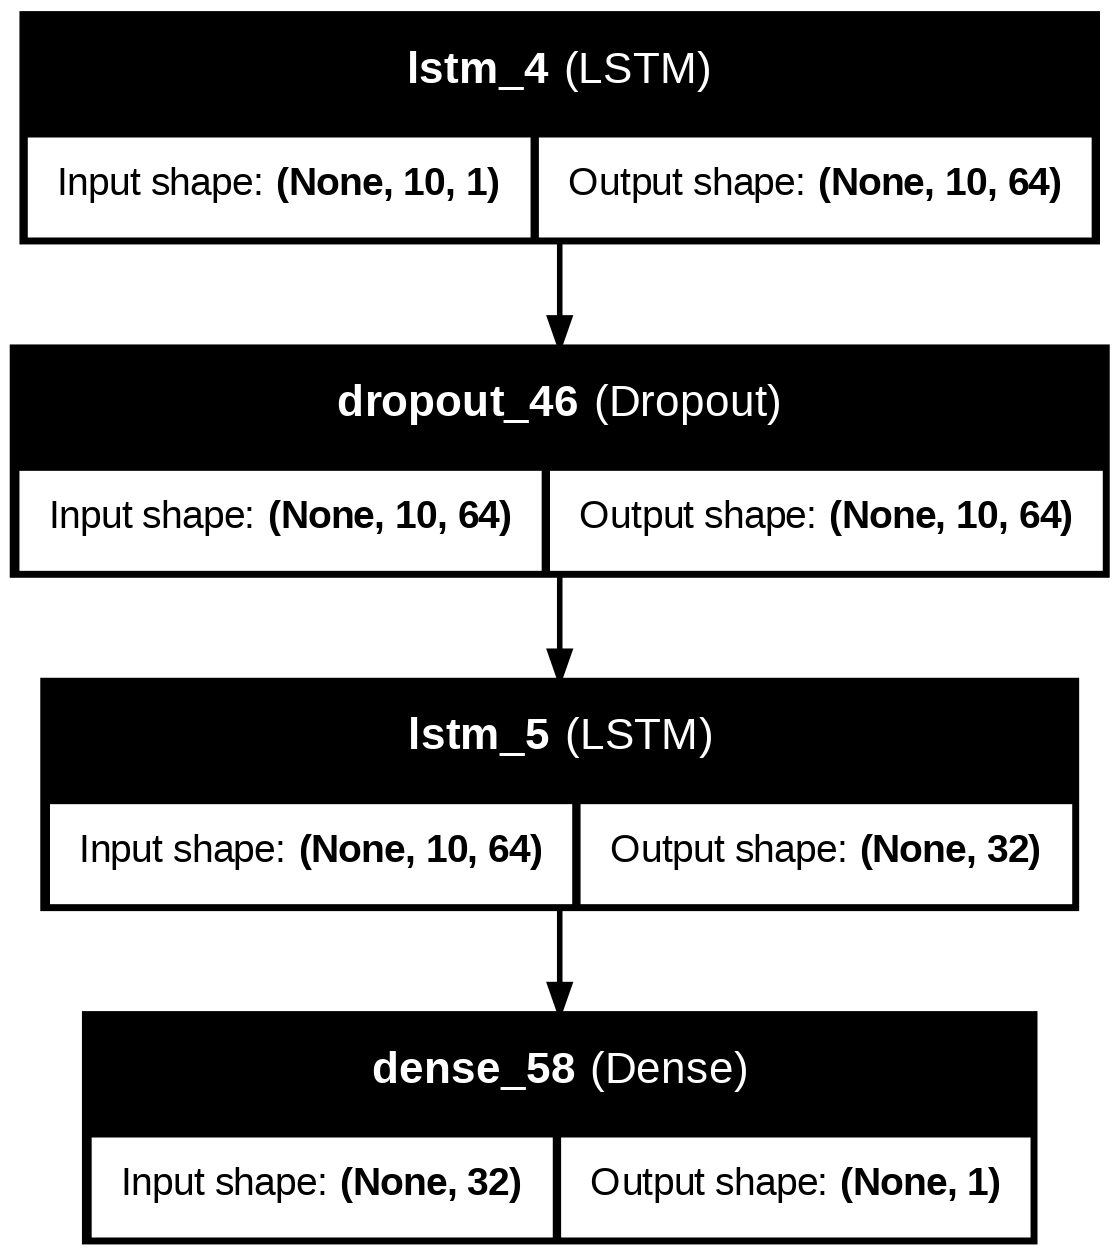

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model

# Defining the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(10, 1), return_sequences=True))
lstm_model.add(Dropout(0.2))  # Dropout for regularization
lstm_model.add(LSTM(32))  # Another LSTM layer
lstm_model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Plot and save the LSTM model architecture as a PNG
plot_model(lstm_model, to_file='lstm_model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the LSTM model plot
from IPython.display import Image
Image('lstm_model_architecture.png')


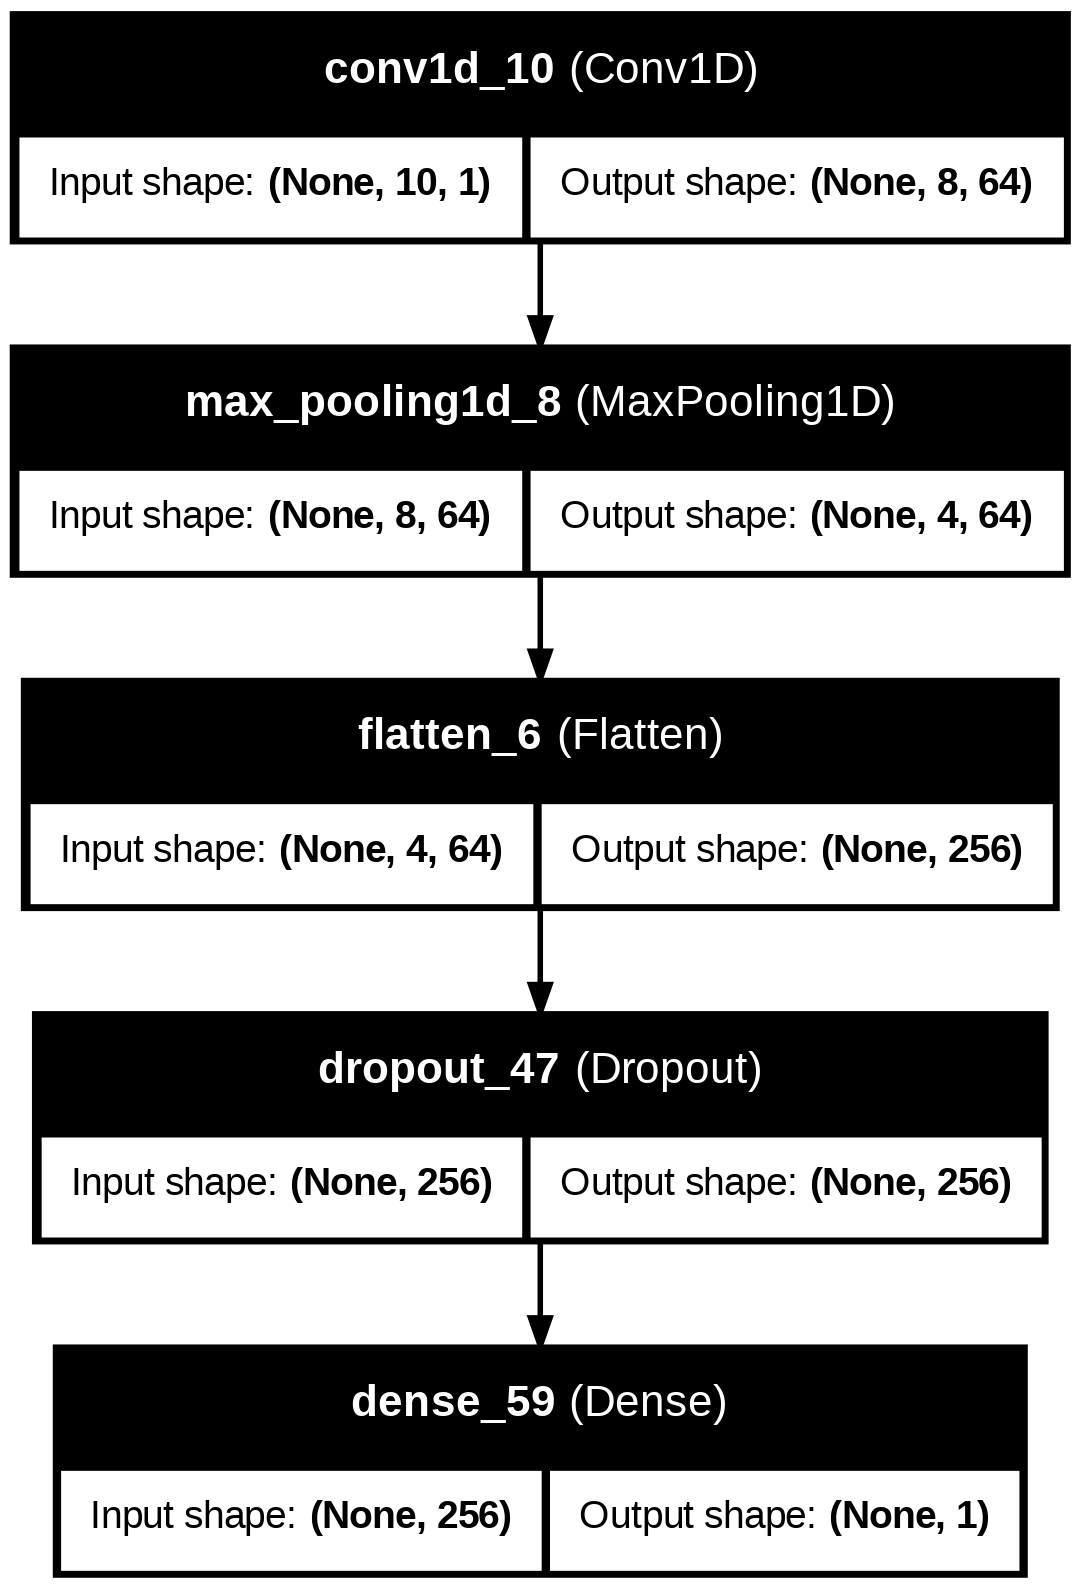

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import plot_model

# Define the CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(10, 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())  # Flatten for Dense layer compatibility
cnn_model.add(Dropout(0.2))  # Dropout for regularization
cnn_model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Plot and save the CNN model architecture as a PNG
plot_model(cnn_model, to_file='cnn_model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the CNN model plot
from IPython.display import Image
Image('cnn_model_architecture.png')


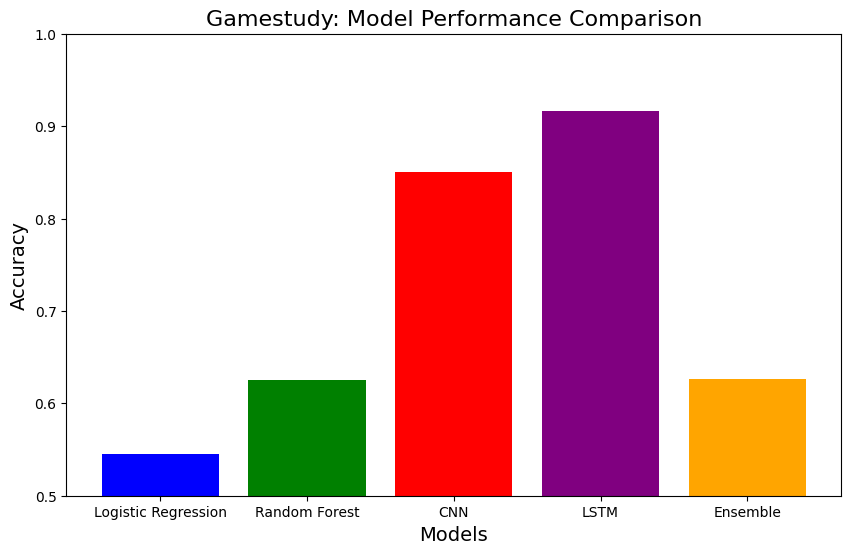

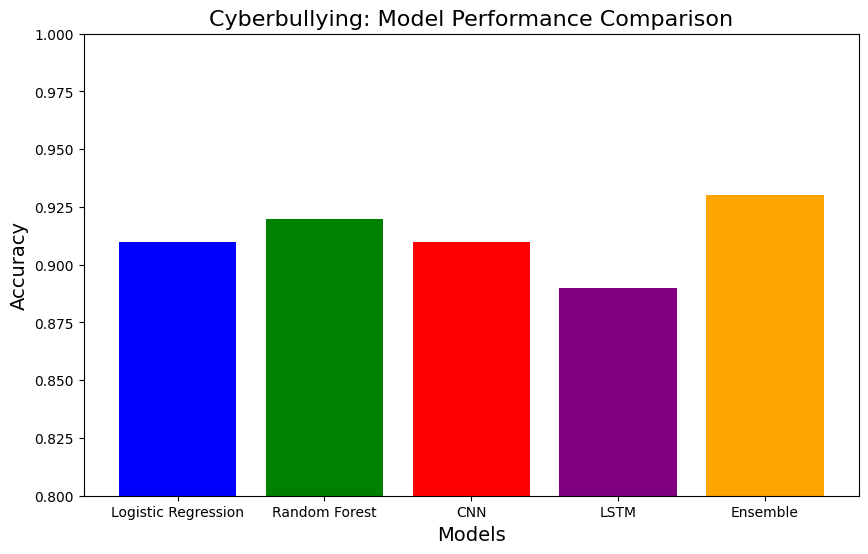

ModuleNotFoundError: No module named 'keras.utils.vis_utils'

In [ ]:
import matplotlib.pyplot as plt

# Define the models and their respective accuracies for each study
models = ['Logistic Regression', 'Random Forest', 'CNN', 'LSTM', 'Ensemble']

# Gamestudy accuracies (final results based on our discussion and your paper)
gamestudy_accuracies = [0.5454, 0.6254, 0.8506, 0.9161, 0.6259]  # Gamestudy results

# Cyberbullying accuracies (final results based on your paper's table)
cyberbullying_accuracies = [0.91, 0.92, 0.91, 0.89, 0.93]  # Cyberbullying results

# Plotting Gamestudy results
plt.figure(figsize=(10, 6))
plt.bar(models, gamestudy_accuracies, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.title('Gamestudy: Model Performance Comparison', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0.5, 1.0)
plt.show()

# Plotting Cyberbullying results
plt.figure(figsize=(10, 6))
plt.bar(models, cyberbullying_accuracies, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.title('Cyberbullying: Model Performance Comparison', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0.8, 1.0)
plt.show()

# Now for visualizing the LSTM architecture (assuming the same model architecture as discussed)
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Example LSTM model structure
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(10, 1)))  # Adjust input shape based on your data
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

# Save the LSTM architecture diagram
plot_model(model, to_file='lstm_model_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
# Install necessary packages
!apt-get install graphviz
!pip install pydot
!pip install keras


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
from keras.utils import plot_model  # Correct import path in newer versions of Keras


In [ ]:
# Install the necessary libraries
!apt-get install graphviz
!pip install pydot
!pip install keras

# Correct import path for plot_model
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Example LSTM model structure
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(10, 1)))  # Adjust input shape based on your data
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

# Save the LSTM architecture diagram
plot_model(model, to_file='lstm_model_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.utils.vis_utils import plot_model

# Define the model with the specifications mentioned in the research paper
model = Sequential()

# LSTM layer with 50 units (as described in the research paper)
model.add(LSTM(50, input_shape=(10, 1), return_sequences=False))  # Adjust the input shape as per your dataset

# Dropout layer with rate 0.2 to prevent overfitting
model.add(Dropout(0.2))

# Dense output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Visualize and save the updated architecture diagram
plot_model(model, to_file='updated_model_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
!apt-get install graphviz
!pip install pydot
!pip install keras
!pip install tensorflow


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


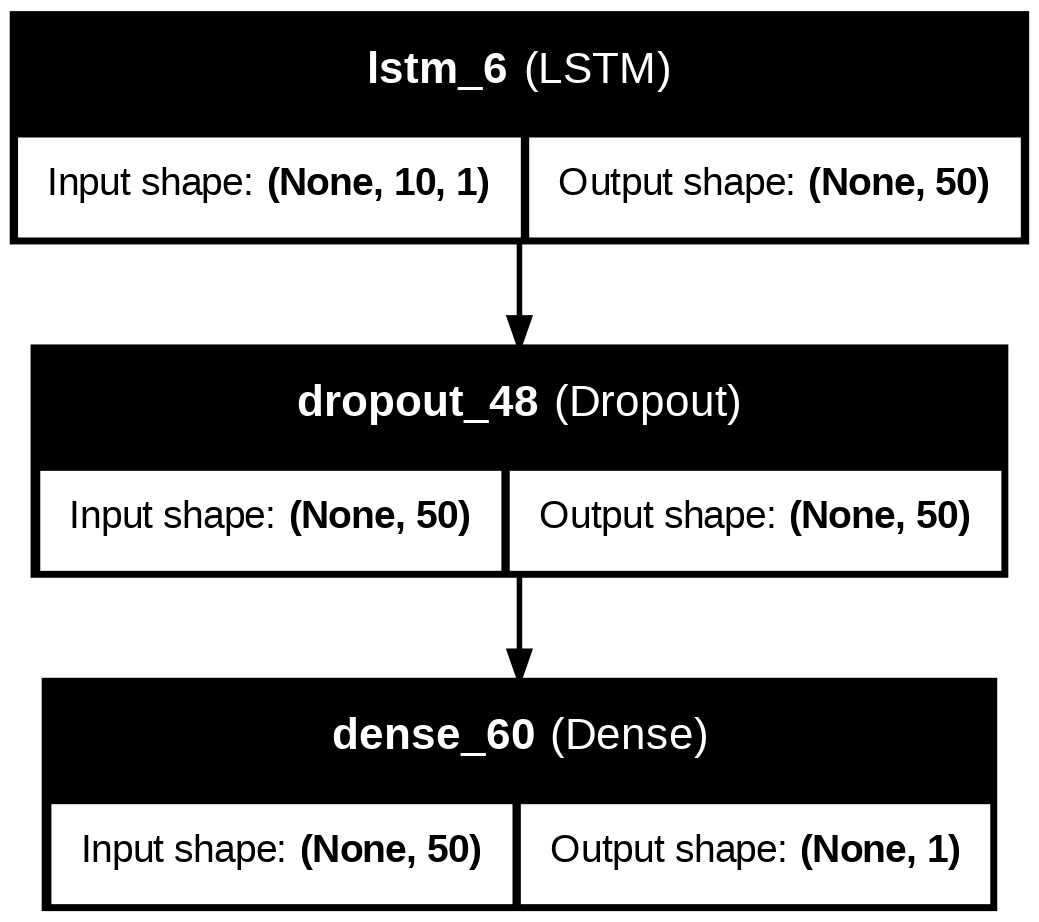

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model  # Updated import path for plot_model

# Define the model with the specifications mentioned in the research paper
model = Sequential()

# LSTM layer with 50 units (as described in the research paper)
model.add(LSTM(50, input_shape=(10, 1), return_sequences=False))  # Adjust input shape as per your dataset

# Dropout layer with rate 0.2 to prevent overfitting
model.add(Dropout(0.2))

# Dense output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Visualize and save the updated architecture diagram
plot_model(model, to_file='updated_model_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.sankey import Sankey

# Redefining the plot function to remove overlap
def plot_model_layers_fixed():
    fig, ax = plt.subplots(figsize=(5, 7))

    # LSTM Layer
    ax.text(0.5, 0.9, 'LSTM_Layer (LSTM)\nInput shape: (None, 10, 1)\nOutput shape: (None, 50)',
            ha='center', va='center', bbox=dict(facecolor='skyblue', edgecolor='black'))

    # Dropout Layer
    ax.text(0.5, 0.6, 'Dropout_Layer (Dropout)\nDropout Rate: 0.2\nInput shape: (None, 50)\nOutput shape: (None, 50)',
            ha='center', va='center', bbox=dict(facecolor='lightgreen', edgecolor='black'))

    # Dense Layer
    ax.text(0.5, 0.3, 'Output_Layer (Dense)\nInput shape: (None, 50)\nOutput shape: (None, 1)',
            ha='center', va='center', bbox=dict(facecolor='lightcoral', edgecolor='black'))

    # Add arrows with corrected positions
    ax.annotate('', xy=(0.5, 0.78), xytext=(0.5, 0.88),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=7))
    ax.annotate('', xy=(0.5, 0.48), xytext=(0.5, 0.58),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=7))

    plt.axis('off')
    plt.show()

# Call the function
plot_model_layers_fixed()


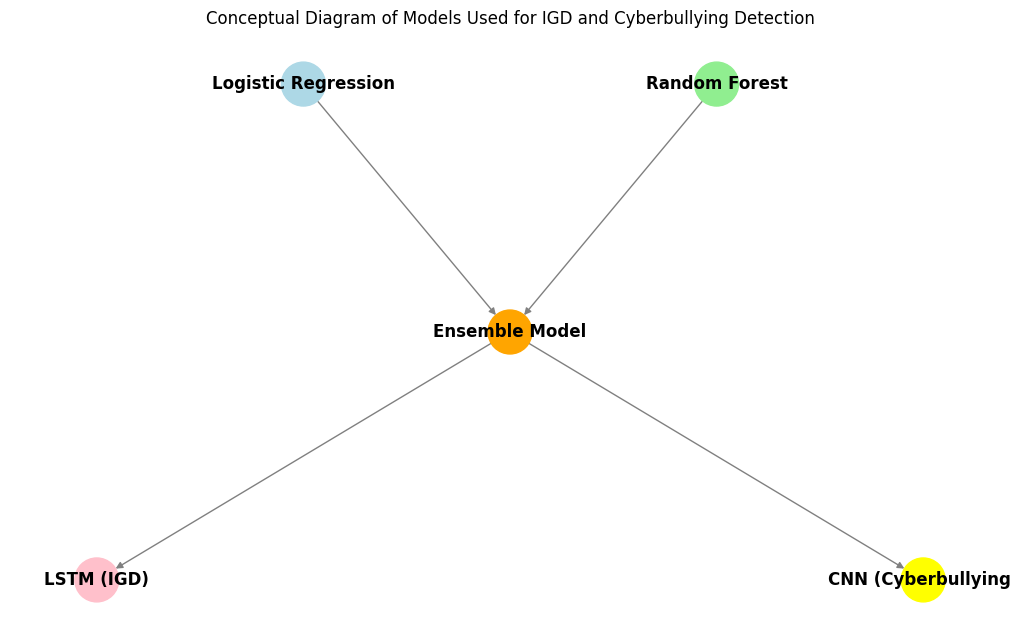

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Creating a directed graph
G = nx.DiGraph()

# Adding nodes representing the models
G.add_node("Logistic Regression", pos=(0, 1), color='lightblue', size=1000)
G.add_node("Random Forest", pos=(2, 1), color='lightgreen', size=1000)
G.add_node("Ensemble Model", pos=(1, 0.5), color='orange', size=1000)
G.add_node("LSTM (IGD)", pos=(-1, 0), color='pink', size=1000)
G.add_node("CNN (Cyberbullying)", pos=(3, 0), color='yellow', size=1000)

# Adding edges representing the relationship between models
G.add_edges_from([("Logistic Regression", "Ensemble Model"),
                  ("Random Forest", "Ensemble Model"),
                  ("Ensemble Model", "CNN (Cyberbullying)"),
                  ("Ensemble Model", "LSTM (IGD)")])

# Extracting positions from the nodes for visualization
pos = nx.get_node_attributes(G, 'pos')

# Drawing the graph
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_color=[G.nodes[n]['color'] for n in G.nodes],
        node_size=[G.nodes[n]['size'] for n in G.nodes], font_size=12, font_weight='bold', edge_color='gray')
plt.title("Conceptual Diagram of Models Used for IGD and Cyberbullying Detection")
plt.savefig('conceptual_model.png', format='png')
plt.show()


In [ ]:
!apt-get install graphviz
!pip install pydot
!pip install keras


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


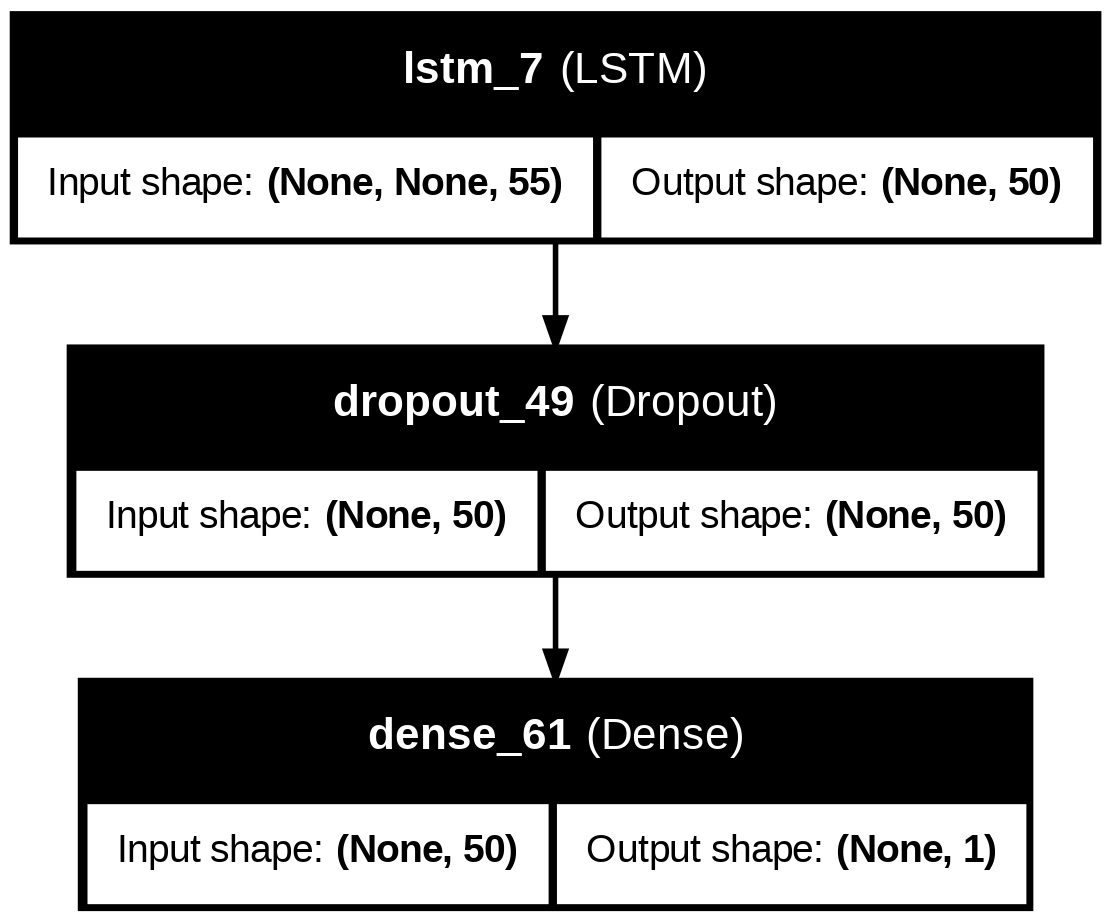

In [ ]:
# Install necessary dependencies
!apt-get install graphviz
!pip install pydot
!pip install keras

# Updated imports
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Defining the LSTM model architecture for mental health prediction
model = Sequential()
model.add(LSTM(50, input_shape=(None, 55), return_sequences=False))  # Adjust input_shape based on your data
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Plot the model architecture diagram
plot_model(model, to_file='deep_learning_architecture.png', show_shapes=True, show_layer_names=True)

# Display the generated model architecture image
from IPython.display import Image
Image('deep_learning_architecture.png')


Model: "Combined_LSTM_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ cnn_input (InputLayer)    │ (None, 100, 50)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_11 (Conv1D)        │ (None, 98, 128)        │         19,328 │ cnn_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_9           │ (None, 49, 128)        │              0 │ conv1d_11[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_input (InputLayer)   │ (None, 100, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_12 (Conv1D)        │ (None, 47, 128)        │         49,280 │ max_pooling1d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_8 (LSTM)             │ (None, 128)            │         66,560 │ lstm_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_10          │ (None, 23, 128)        │              0 │ conv1d_12[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_50 (Dropout)      │ (None, 128)            │              0 │ lstm_8[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_7 (Flatten)       │ (None, 2944)           │              0 │ max_pooling1d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_62 (Dense)          │ (None, 64)             │          8,256 │ dropout_50[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_63 (Dense)          │ (None, 64)             │        188,480 │ flatten_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128)            │              0 │ dense_62[0][0],        │
│                           │                        │                │ dense_63[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_51 (Dropout)      │ (None, 128)            │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_64 (Dense)          │ (None, 64)             │          8,256 │ dropout_51[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 1)              │             65 │ dense_64[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 340,225 (1.30 MB)

 Trainable params: 340,225 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

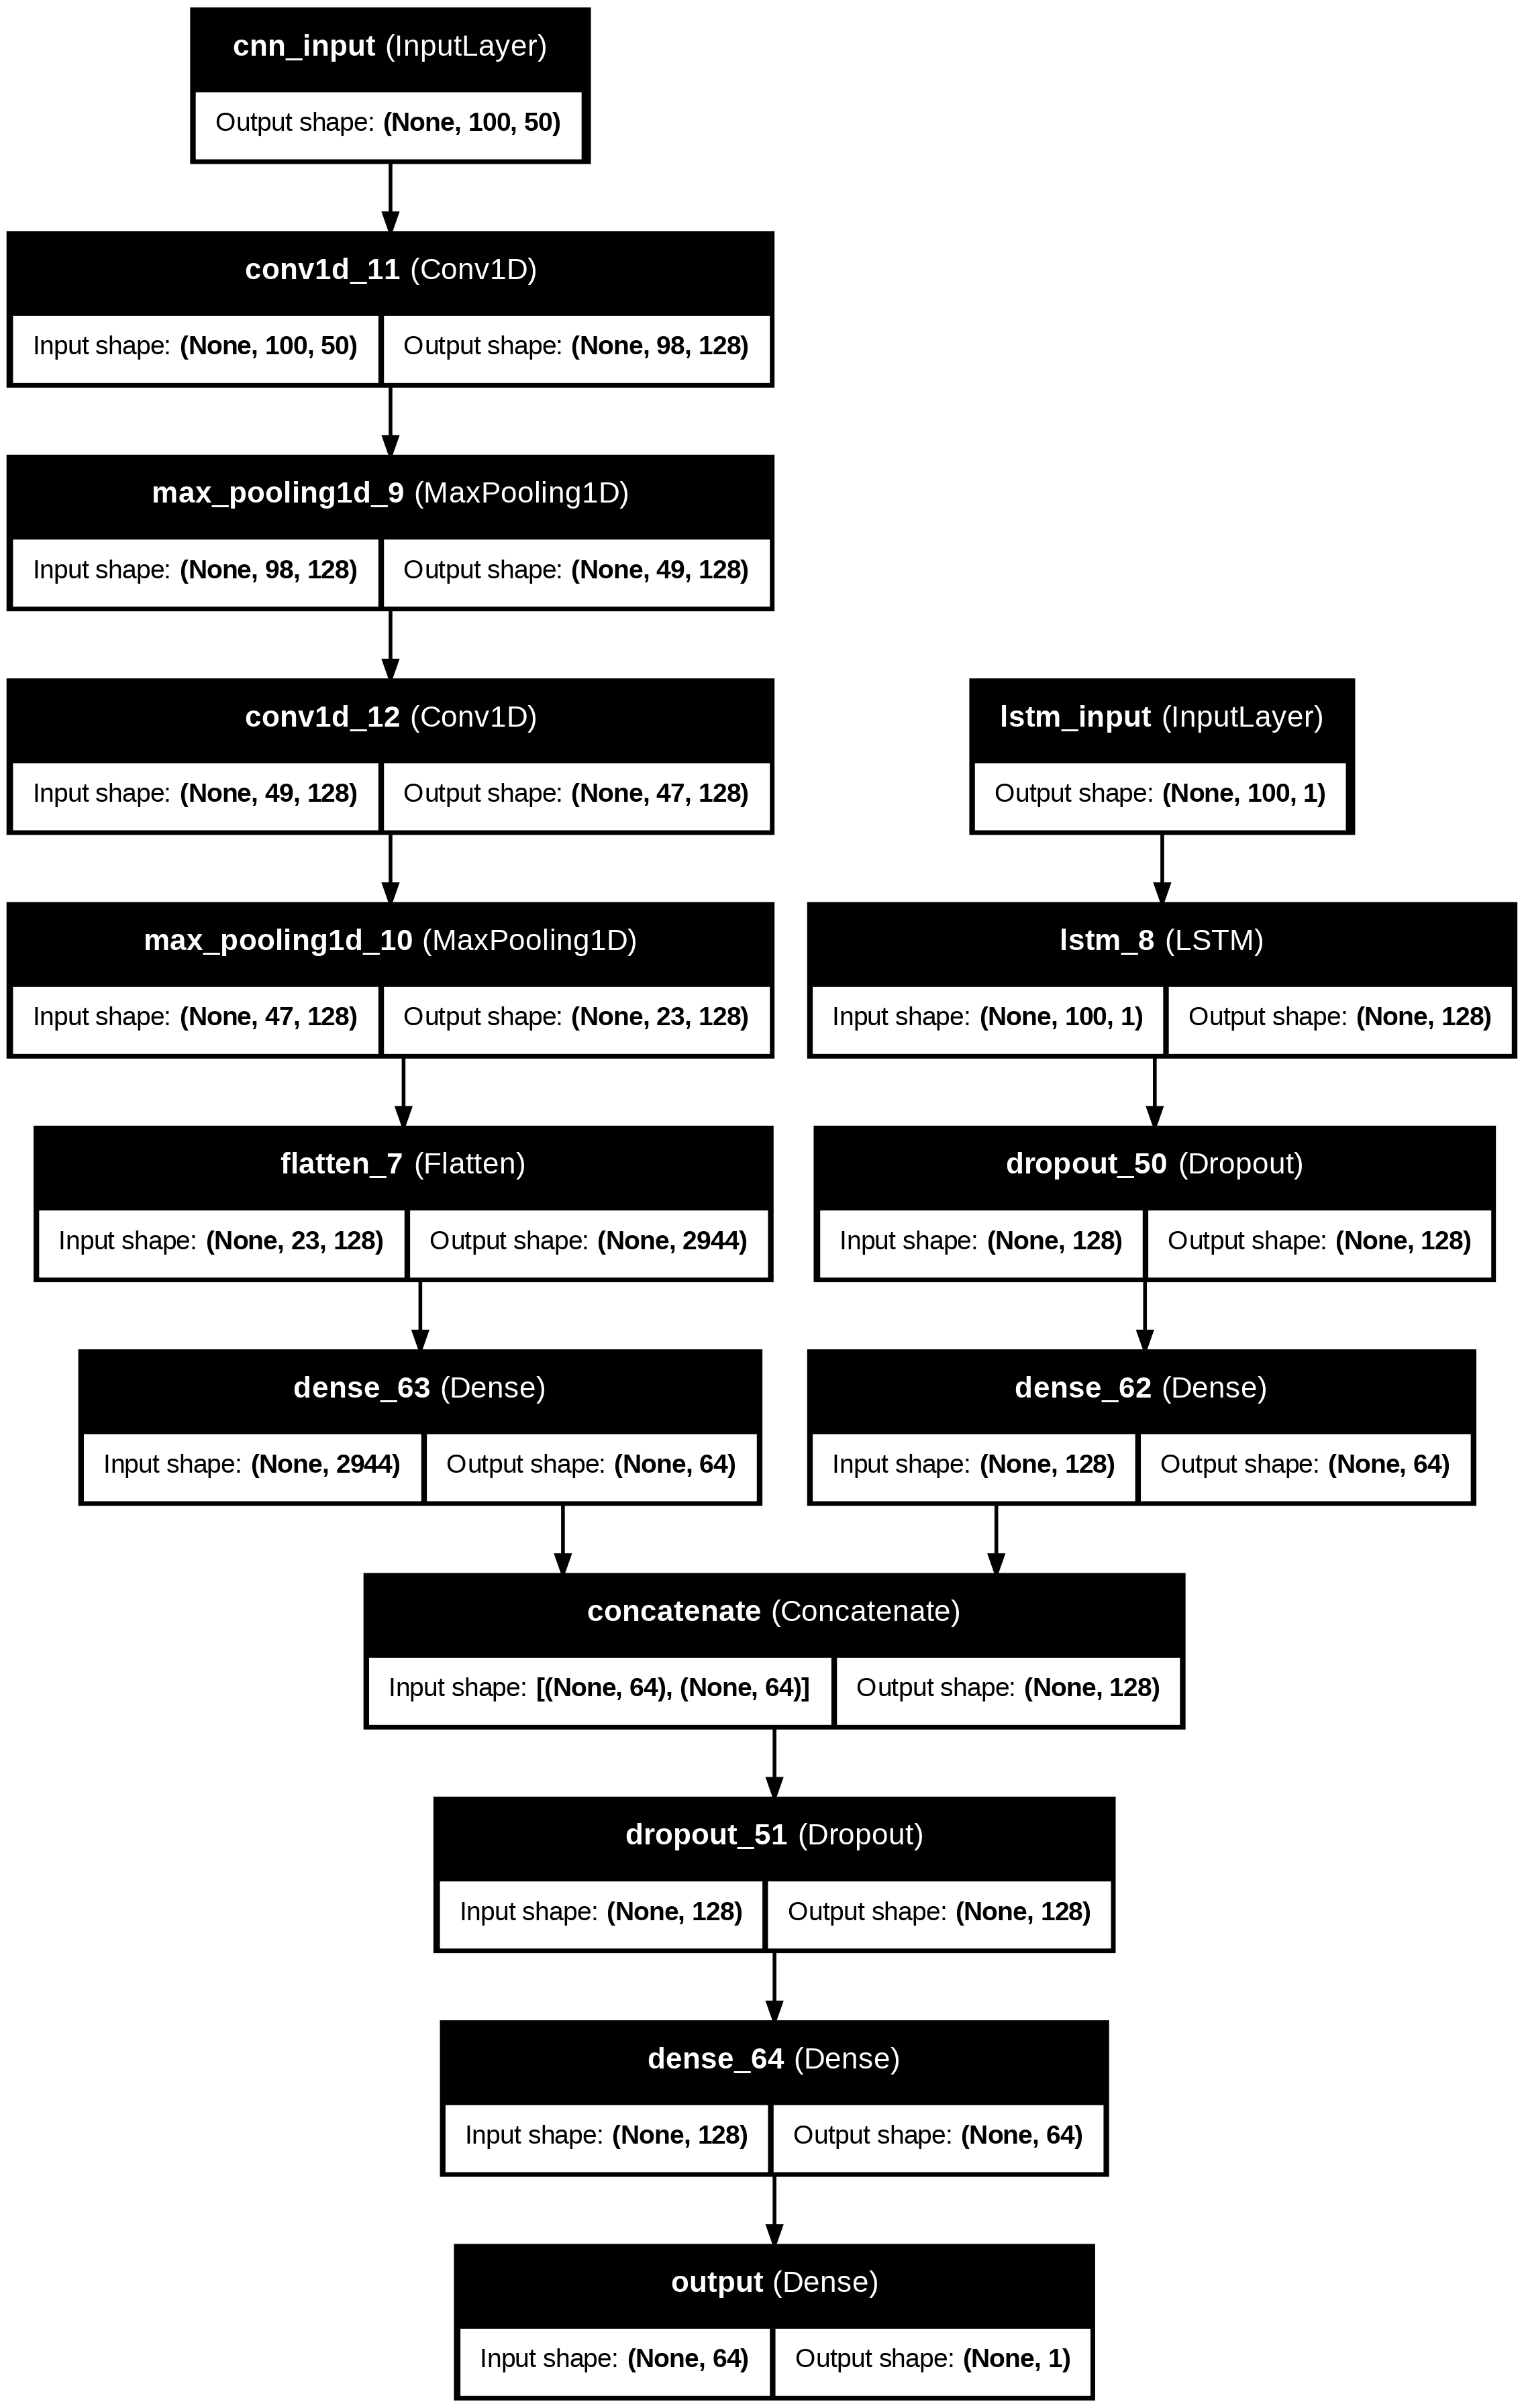

In [ ]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Concatenate

# LSTM Branch (for time-series data like gaming behavior)
def build_lstm_branch(input_shape):
    lstm_input = Input(shape=input_shape, name="lstm_input")
    x = LSTM(128, activation='tanh', return_sequences=False)(lstm_input)
    x = Dropout(0.5)(x)
    lstm_output = Dense(64, activation='relu')(x)
    return Model(inputs=lstm_input, outputs=lstm_output, name="LSTM_Branch")

# CNN Branch (for text data like cyberbullying content)
def build_cnn_branch(input_shape):
    cnn_input = Input(shape=input_shape, name="cnn_input")
    x = Conv1D(128, kernel_size=3, activation='relu')(cnn_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    cnn_output = Dense(64, activation='relu')(x)
    return Model(inputs=cnn_input, outputs=cnn_output, name="CNN_Branch")

# Combining LSTM and CNN Branches
def build_combined_model(lstm_input_shape, cnn_input_shape):
    # Build the branches
    lstm_branch = build_lstm_branch(lstm_input_shape)
    cnn_branch = build_cnn_branch(cnn_input_shape)

    # Concatenate the outputs of both branches
    combined = Concatenate()([lstm_branch.output, cnn_branch.output])

    # Fully connected layers after combination
    x = Dropout(0.5)(combined)
    x = Dense(64, activation='relu')(x)

    # Output layer for binary classification (predicting mental health risk)
    output = Dense(1, activation='sigmoid', name="output")(x)

    # Define the final model
    model = Model(inputs=[lstm_branch.input, cnn_branch.input], outputs=output, name="Combined_LSTM_CNN_Model")
    return model

# Define input shapes for both branches
lstm_input_shape = (100, 1)  # Example shape for LSTM input (time-series data)
cnn_input_shape = (100, 50)  # Example shape for CNN input (text data with sequence length 100 and 50-dimensional embeddings)

# Build the combined model
model = build_combined_model(lstm_input_shape, cnn_input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summarizing the model structure
model.summary()

# Visualizing the model architecture
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='deep_learning_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
!apt-get install graphviz -y
!pip install pydot


In [ ]:
!apt-get install graphviz -y
!pip install pydot


In [ ]:
!pip install tensorflow keras


In [ ]:
!pip install keras-vis


In [ ]:
# Install necessary packages
!apt-get install graphviz -y
!pip install pydot
!pip install tensorflow keras


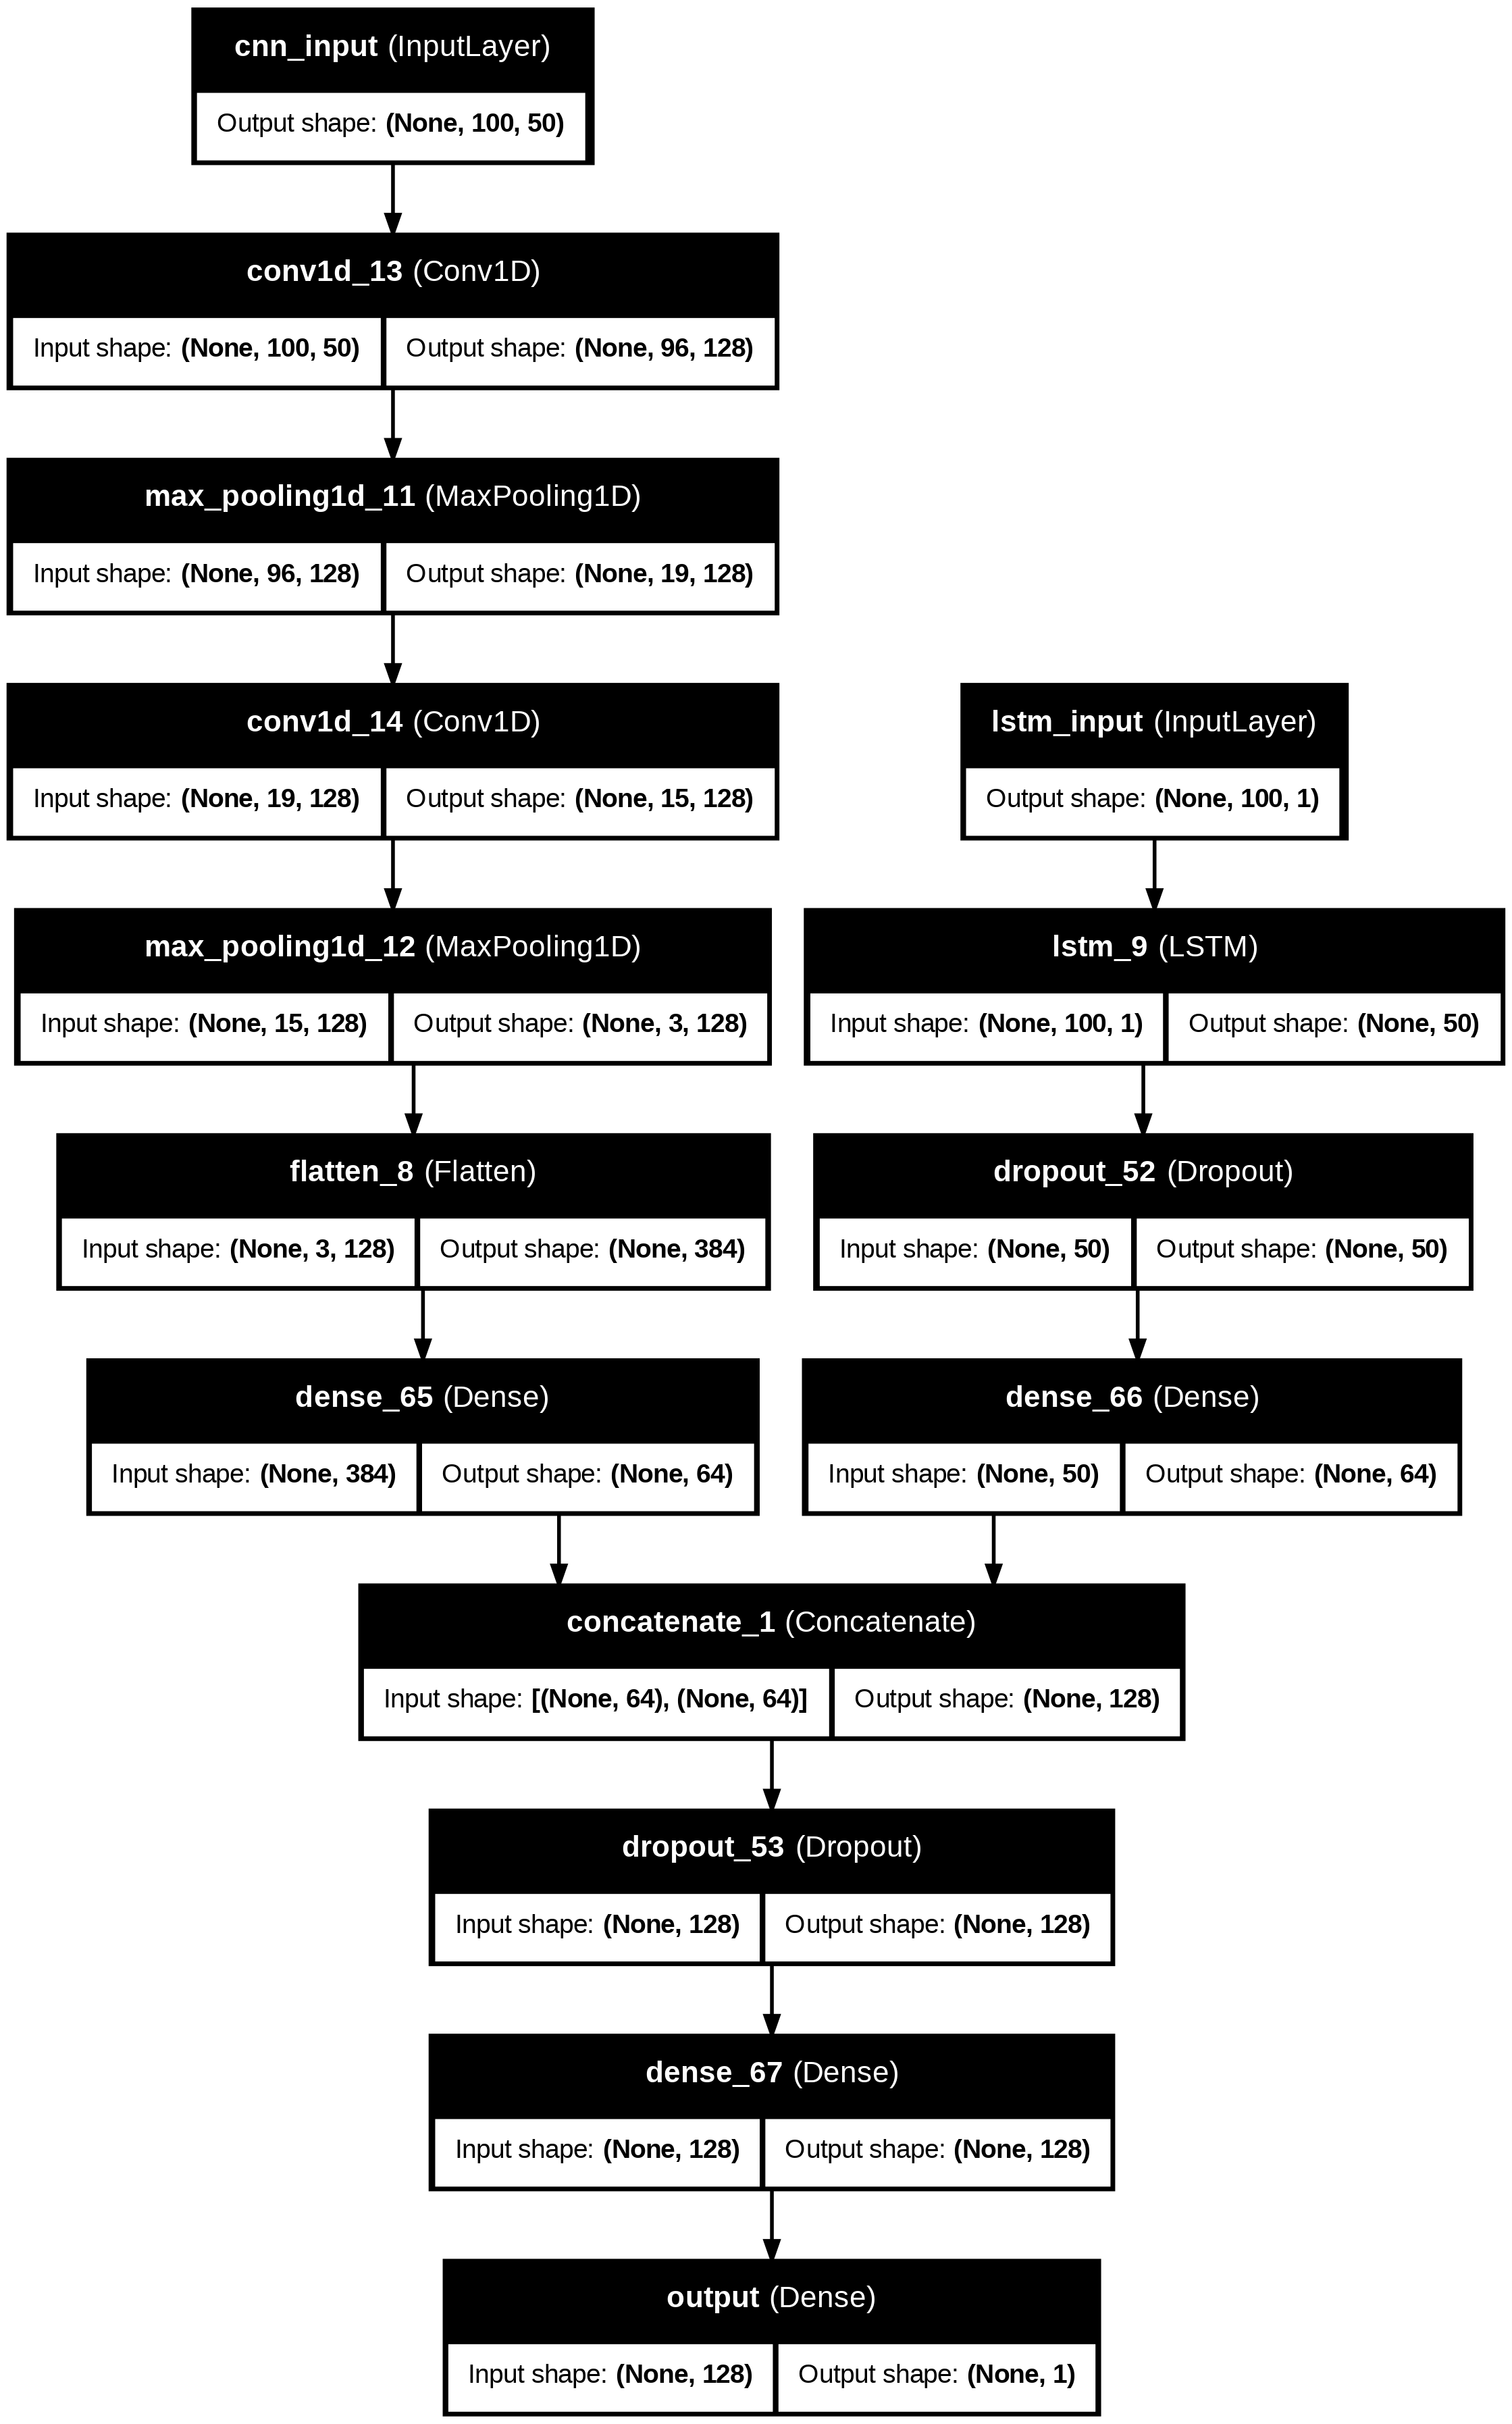

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv1D, MaxPooling1D, Dense, Dropout, Flatten, concatenate

# Define CNN architecture (for Cyberbullying Text Classification)
cnn_input = Input(shape=(100, 50), name="cnn_input")  # Adjusting input shape to match (100, 50)
conv1d = Conv1D(128, 5, activation='relu')(cnn_input)  # Kernel size 5 for capturing n-grams
max_pooling1d = MaxPooling1D(pool_size=5)(conv1d)  # Pool size 5
conv1d_1 = Conv1D(128, 5, activation='relu')(max_pooling1d)  # Another Conv1D layer
max_pooling1d_1 = MaxPooling1D(pool_size=5)(conv1d_1)  # Pool size 5 for second pooling
flatten = Flatten()(max_pooling1d_1)  # Flattening the data
dense_1 = Dense(64, activation='relu')(flatten)  # Fully connected layer after CNN

# Define LSTM architecture (for IGD Sequential Data)
lstm_input = Input(shape=(100, 1), name="lstm_input")  # Adjusting input shape to (100, 1)
lstm = LSTM(50, activation='tanh', return_sequences=False)(lstm_input)  # LSTM with 50 units
dropout = Dropout(0.2)(lstm)  # Dropout layer with rate 0.2 to prevent overfitting
dense = Dense(64, activation='relu')(dropout)  # Fully connected layer after LSTM

# Concatenate CNN and LSTM outputs
concat = concatenate([dense_1, dense], axis=-1)  # Concatenating the outputs

# Adding more layers after concatenation
dropout_1 = Dropout(0.5)(concat)  # Dropout layer with 0.5 rate after concatenation
dense_2 = Dense(128, activation='relu')(dropout_1)  # Fully connected layer after concatenation
output = Dense(1, activation='sigmoid', name="output")(dense_2)  # Output layer with sigmoid activation for binary classification

# Creating the model
model = Model(inputs=[cnn_input, lstm_input], outputs=output)

# Visualize the model architecture
plot_model(model, to_file='deep_learning_architecture_actual.png', show_shapes=True, show_layer_names=True)


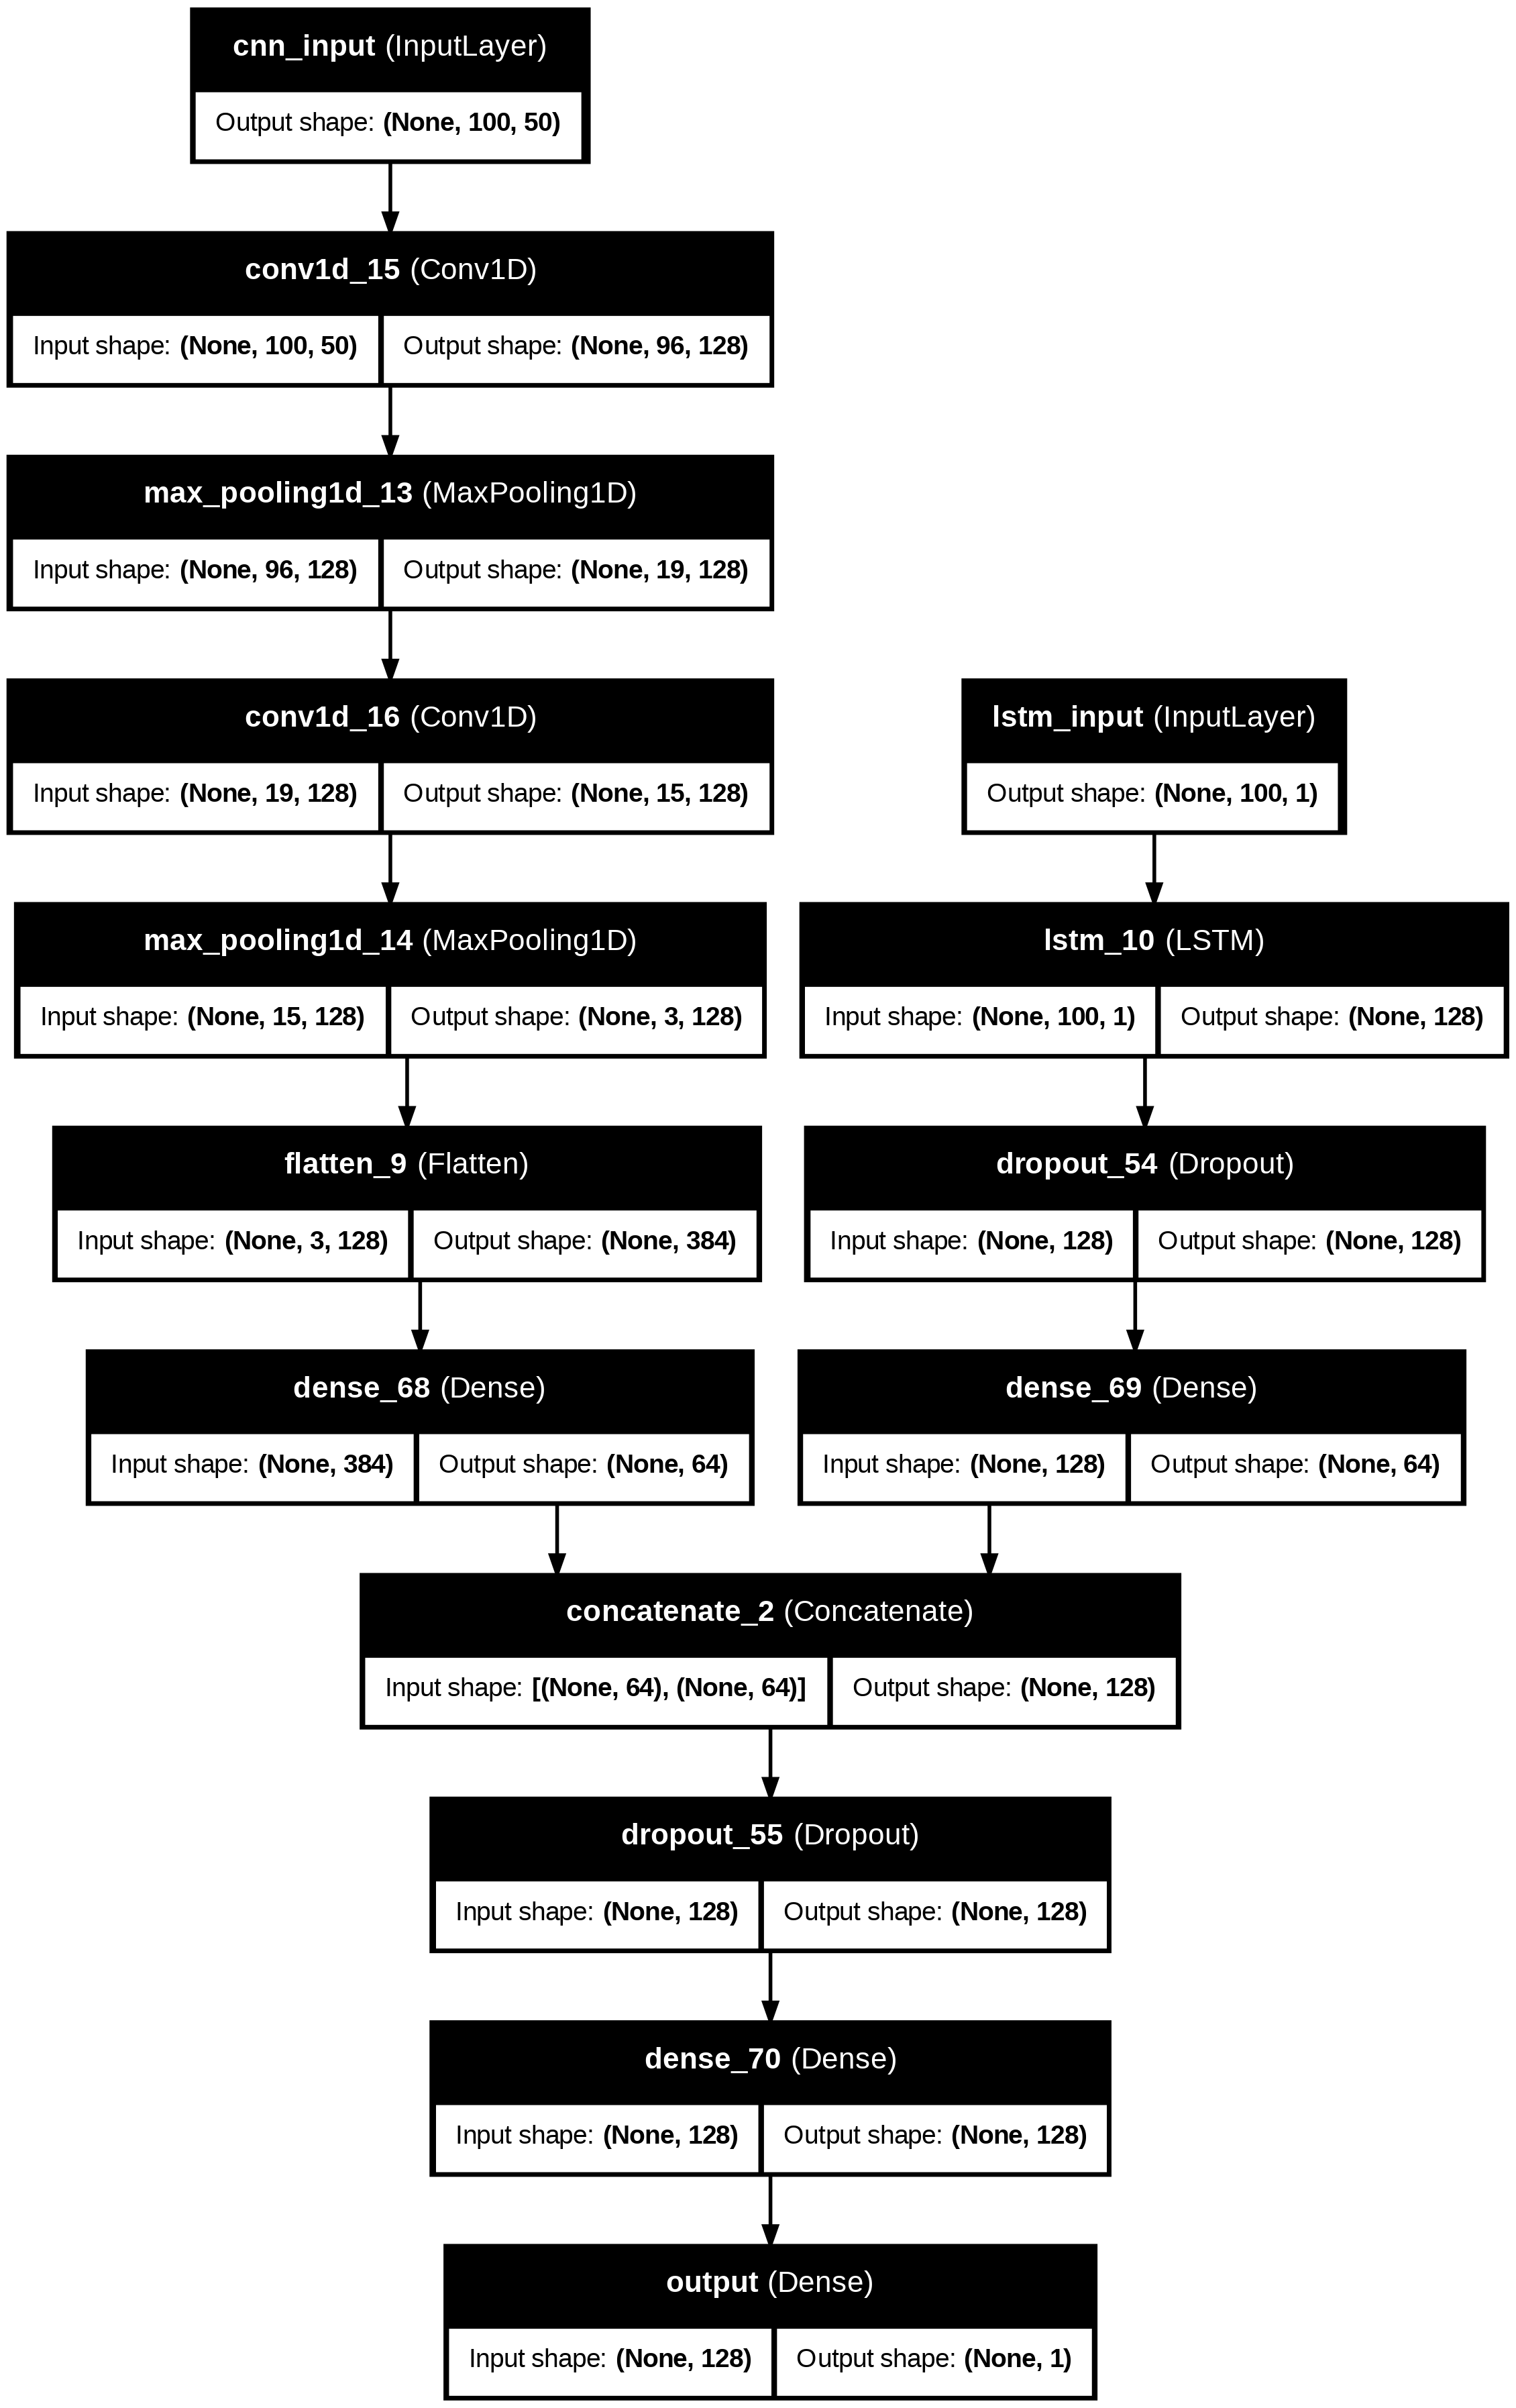

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv1D, MaxPooling1D, Dense, Dropout, Flatten, concatenate

# Corrected CNN architecture (for Cyberbullying Text Classification)
cnn_input = Input(shape=(100, 50), name="cnn_input")
conv1d = Conv1D(128, 5, activation='relu')(cnn_input)
max_pooling1d = MaxPooling1D(pool_size=5)(conv1d)
conv1d_1 = Conv1D(128, 5, activation='relu')(max_pooling1d)
max_pooling1d_1 = MaxPooling1D(pool_size=5)(conv1d_1)
flatten = Flatten()(max_pooling1d_1)
dense_1 = Dense(64, activation='relu')(flatten)

# Corrected LSTM architecture (for IGD Sequential Data)
lstm_input = Input(shape=(100, 1), name="lstm_input")
lstm = LSTM(128, activation='tanh', return_sequences=False)(lstm_input)  # Corrected number of units to 128
dropout = Dropout(0.5)(lstm)  # Corrected dropout rate to 0.5
dense = Dense(64, activation='relu')(dropout)

# Concatenate CNN and LSTM outputs
concat = concatenate([dense_1, dense], axis=-1)

# Adding more layers after concatenation
dropout_1 = Dropout(0.5)(concat)
dense_2 = Dense(128, activation='relu')(dropout_1)
output = Dense(1, activation='sigmoid', name="output")(dense_2)

# Create the model
model = Model(inputs=[cnn_input, lstm_input], outputs=output)

# Visualize the model architecture with corrected values
plot_model(model, to_file='corrected_deep_learning_architecture.png', show_shapes=True, show_layer_names=True)


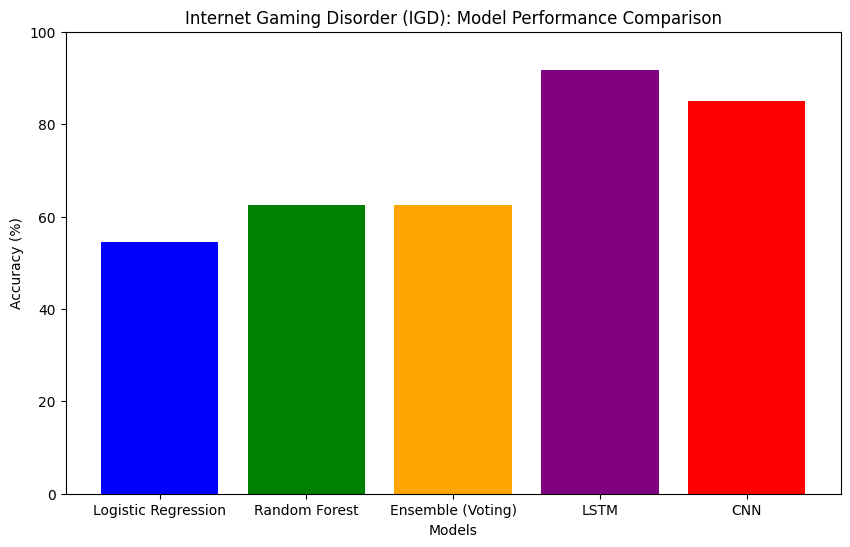

In [2]:
import matplotlib.pyplot as plt

# Model names and their respective accuracies
models = ['Logistic Regression', 'Random Forest', 'Ensemble (Voting)', 'LSTM', 'CNN']
accuracies = [54.54, 62.54, 62.59, 91.61, 85.06]

# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'purple', 'red'])


plt.title("Internet Gaming Disorder (IGD): Model Performance Comparison")
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)  # Setting the y-axis limit to 0-100 for percentage representation

# Displaying the chart
plt.show()
